# Align two MERFISH brain sections using modified LDDMM with both cell density and gene exp for select DEGs and all genes.
#### Version: Using automated landmark points. 

Data source: Vizgen Data Release V1.0. May 2021 (https://info.vizgen.com/mouse-brain-map?submissionGuid=955163f1-3119-42d9-bcbf-e0255e6e7d17) 

Dataset used: Slice 2 Replicate 2, Slice 2 Replicate 3 

Code: Iris Kwon (skwon38@jh.edu)

In [1]:
import os
import matplotlib.pyplot as plt
##### %%time
import torch
import copy
from torch.nn.functional import grid_sample
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad 
import landmark as lm 
# import STalign
# # from STalign import STalign
# dir(STalign)

/Users/iriskwon/miniforge3/envs/stalign-env/lib/python3.10/site-packages/anndata/_core/anndata.py:22: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy import sparse


### 00. Define functions for STalign2

In [67]:
def normalize(arr, t_min=0, t_max=1):
    """Linearly normalizes an array between two specifed values.
    
    Parameters
    ----------
    arr : numpy array
        array to be normalized
    t_min : int or float
        Lower bound of normalization range
    t_max : int or float
        Upper bound of normalization range
    
    Returns
    -------
    norm_arr : numpy array
        1D array with normalized arr values
        
    """
    
    diff = t_max - t_min
    diff_arr = np.max(arr) - np.min(arr)
    min_ = np.min(arr)
    if diff_arr != 0:
        norm_arr = ((arr - min_)/diff_arr * diff) + t_min
    else:
        norm_arr = np.zeros(arr.shape)
    
    return norm_arr


def rasterize(x, y, g=np.ones(1), dx=15, blur=1.5, expand=1.2, draw=0, wavelet_magnitude=False,use_windowing=True):
    ''' Rasterize a spatial transcriptomics dataset into a density image
    
    Paramters
    ---------
    x : numpy array of length N
        x location of cells
    y : numpy array of length N
        y location of cells
    g : numpy array of length N
        RNA count of cells
        If not given, density image is created
    dx : float
        Pixel size to rasterize data (default 30.0, in same units as x and y)
    blur : float or list of floats
        Standard deviation of Gaussian interpolation kernel.  Units are in 
        number of pixels.  Can be aUse a list to do multi scale.
    expand : float
        Factor to expand sampled area beyond cells. Defaults to 1.1.
    draw : int
        If True, draw a figure every draw points return its handle. Defaults to False (0).
    wavelet_magnitude : bool
        If True, take the absolute value of difference between scales for raster images.
        When using this option blur should be sorted from greatest to least.
    
        
    Returns
    -------
    X  : numpy array
        Locations of pixels along the x axis
    Y  : numpy array
        Locations of pixels along the y axis
    M : numpy array
        A rasterized image with len(blur) channels along the first axis
    fig : matplotlib figure handle
        If draw=True, returns a figure handle to the drawn figure.
        
    Raises
    ------    
    Exception 
        If wavelet_magnitude is set to true but blur is not sorted from greatest to least.
        
        
    
    Examples
    --------
    Rasterize a dataset at 30 micron pixel size, with three kernels.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000)
    
    Rasterize a dataset at 30 micron pixel size, with three kernels, using difference between scales.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000, wavelet_magnitude=True)
        
        
    '''
    
    # set blur to a list
    if not isinstance(blur,list):
        blur = [blur]
    nb = len(blur)
    blur = np.array(blur)
    n = len(x)
    maxblur = np.max(blur) # for windowing
    
    
    
    if wavelet_magnitude and np.any(blur != np.sort(blur)[::-1]):
        raise Exception('When using wavelet magnitude, blurs must be sorted from greatest to least')
    
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
    miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand
    X_ = np.arange(minx,maxx,dx)
    Y_ = np.arange(miny,maxy,dx)
    
    X = np.stack(np.meshgrid(X_,Y_)) # note this is xy order, not row col order

    W = np.zeros((X.shape[1],X.shape[2],nb))

    
    if draw: fig,ax = plt.subplots()
    count = 0
    
    g = np.resize(g,x.size)
    if(not (g==1.0).all()):
        g = normalize(g)
    #if np.sum(g) == 0:
    #    print('no gene exp')
    #    return X,Y,W, None
    for x_,y_,g_ in zip(x,y,g):
        # to speed things up I should index
        # to do this I'd have to find row and column indices
        #col = np.round((x_ - X_[0])/dx).astype(int)
        #row = np.round((y_ - X_[1])/dx).astype(int)
        #row0 = np.floor(row-blur*3).astype(int)
        #row1 = np.ceil(row+blur*3).astype(int)        
        #rows = np.arange(row0,row1+1)
        

        # this is incrementing one pixel at a time, it is way way faster, 
        # but doesn't use a kernel
        # I[c_,row,col] += 1.0
        # W[row,col] += 1.0
        if not use_windowing: # legacy version
            k = np.exp( - ( (X[0][...,None] - x_)**2 + (X[1][...,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)    
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]

            W += k
        else: # use a small window
            r = int(np.ceil(maxblur*4))
            col = np.round((x_ - X_[0])/dx).astype(int)
            row = np.round((y_ - Y_[0])/dx).astype(int)
            
            row0 = np.floor(row-r).astype(int)
            row1 = np.ceil(row+r).astype(int)                    
            col0 = np.floor(col-r).astype(int)
            col1 = np.ceil(col+r).astype(int)
            
            # we need boundary conditions
            row0 = np.minimum(np.maximum(row0,0),W.shape[0]-1)
            row1 = np.minimum(np.maximum(row1,0),W.shape[0]-1)
            col0 = np.minimum(np.maximum(col0,0),W.shape[1]-1)
            col1 = np.minimum(np.maximum(col1,0),W.shape[1]-1)
            
           
            k =  np.exp( - ( (X[0][row0:row1+1,col0:col1+1,None] - x_)**2 + (X[1][row0:row1+1,col0:col1+1,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)  
            else:
                k=k
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]
            W[row0:row1+1,col0:col1+1,:] += k #range of voxels -oka
            
        
            
        

        if draw:
            if not count%draw or count==(x.shape[0]-1):
                print(f'{count} of {x.shape[0]}')

                ax.cla()
                toshow = W-np.min(W,axis=(0,1),keepdims=True)
                toshow = toshow / np.max(toshow,axis=(0,1),keepdims=True)
                
                if nb >= 3:
                    toshow = toshow[...,:3]
                elif nb == 2:
                    toshow = toshow[...,[0,1,0]]
                elif nb == 1:
                    toshow = toshow[...,[0,0,0]]
                
                ax.imshow(np.abs(toshow))
                fig.canvas.draw()

        count += 1
    W = np.abs(W)
    # we will permute so channels are on first axis
    W = W.transpose((-1,0,1))
    extent = (X_[0],X_[-1],Y_[0],Y_[-1])
    
    # rename
    X = X_
    Y = Y_
    if draw:
        output = X,Y,W,fig
    else:
        output = X,Y,W
    return output

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T
    
import torch

def to_A(L,T):
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

def extent_from_x(xJ): #bounds for image to plot - ok
    dJ = [x[1]-x[0] for x in xJ] #step size between pixels along the axes - but is this difference between x and y?
    extentJ = ((xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    
    return extentJ

def clip(I):

    Ic = torch.clone(I)
    Ic[Ic<0]=0
    Ic[Ic>1]=1
    return Ic

def interp(x,I,phii,**kwargs):
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

def extent_from_x(xJ):
    ''' Given a set of pixel locations, returns an extent 4-tuple for use with np.imshow.
    
    Note inputs are locations of pixels along each axis, i.e. row column not xy.
    
    Parameters
    ----------
    xJ : list of torch tensors
        Location of pixels along each axis
    
    Returns
    -------
    extent : tuple
        (xmin, xmax, ymin, ymax) tuple
    
    Examples
    --------
    
    >>> extent_from_x(xJ)
    >>> fig,ax = plt.subplots()
    >>> ax.imshow(J,extent=extentJ)
    
    '''
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T

In [3]:
def rasterizeByGene(x, y, G, dx=15, blur=1.5, expand=1.2):
    """
    Rasterize each column of a cell by gene matrix into a 2D spatial grid.

    This function takes cell coordinates (x, y) and a matrix 'G' of gene 
    expression values (cells × genes), and rasterizes each gene into
    a continuous 2D image using the `rasterize` function. It returns 
    both the raw raster images and their flattened, mean-centered forms.

    Parameters
    ----------
    x : array-like, shape (n_cells,)
        X-coordinates of spots or cells.

    y : array-like, shape (n_cells,)
        Y-coordinates of spots or cells.

    G : pandas.DataFrame, shape (n_cells, n_features)
        Matrix of gene expression values or other features to rasterize.
        Each column is rasterized independently.

    dx : float, optional (default: 15)
        Grid resolution parameter passed to `rasterize`. Controls spacing
        between grid points.

    blur : float, optional (default: 1.5)
        Smoothing kernel width used during rasterization. Higher values 
        produce smoother images.

    expand : float, optional (default: 1.2)
        Expansion factor applied to the coordinate range before creating 
        the grid. Prevents edge clipping.

    draw : int, optional (default: 10000)
        Number of points drawn for kernel density or smoothing operations
        inside `rasterize`, if used.

    wavelet_magnitude : bool, optional (default: False)
        Whether to compute wavelet magnitude inside `rasterize`, if supported.

    use_windowing : bool, optional (default: True)
        Whether to apply windowing (edge attenuation) in `rasterize`.

    Returns
    -------
    X : ndarray, shape (n_genes, nrows, ncols) 
        Raw rasterized images for each gene. 
        `X[i]` corresponds to gene `G.columns[i]`.

    Y : ndarray, shape (n_genes, nrows * ncols)
        Flattened and mean-centered version of each rasterized image.
        `Y[i]` contains `X[i].ravel()` with its mean subtracted.

    XI : ndarray, shape (ncols,)
        X-axis coordinates of the raster grid.

    YI : ndarray, shape (nrows,)
        Y-axis coordinates of the raster grid.

    Notes
    -----
    - The raster grid size (nrows, ncols) is determined by the output of 
      `rasterize(x, y, g, dx, blur, expand)`.
    - This function works with genes, PCA components, or any continuous 
      per-cell feature vector.
    - Useful for preparing feature images for spatial alignment frameworks
      such as stAlign.

    """
    nrows=0
    ncols=0
    
    for i in range(G.shape[1]):
        g = np.array(G.iloc[:,i])
        
        XI,YI,I = rasterize(x,y,g=g,dx=dx,blur=blur,expand =expand)
        
        if(i==0):
            # dimensions
            nrows=YI.size
            ncols=XI.size
            X = np.empty([G.shape[1], nrows, ncols])
            Y = np.empty([G.shape[1], nrows*ncols])
        
        # centers data
        X[i] = np.array(I)
        I_ = I.ravel()
        meanI = np.mean(I_)
        I_ -= meanI
        Y[i] = I_
        
        if(i % 10 == 0):
            print(f"{i} out of {G.shape[1]} genes rasterized.")

    
    return X, Y, XI, YI

In [4]:
def LDDMM(xI,I,xJ,J,Ig, Jg, pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaMg=1.0, sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
 
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    Jg = torch.tensor(Jg,device=device,dtype=dtype)
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand # WHY DO IT THIS WAY??
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)] # "a" determines step size of velocity field
        XV = torch.stack(torch.meshgrid(xv),-1) #creating a meshgrid to apply transformation to all points in a grid (creating the 'field' in velocity field)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True) # why does XW have a shape of 3 (aren't there only x and y points? 2D)
        #velocity field start out as a zero vector field - how does it get updated? 
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv) #for plotting purposes
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype) #step in between each set of points
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)] # 5 dimensions of grid of XV/dv - should be similar to XV but not a meshgrid, just points along each axis
    extentF = extent_from_x(fv) #plotting
    FV = torch.stack(torch.meshgrid(fv),-1) # would this not just be the same as XV? print out both and compare 
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0) #smoothing kernel? what is this?

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    

    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,5)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass


    
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
        #print(Xs.shape)
        # transform image
        #AI = interp(xI,I.swapaxes(1,2),Xs.permute(2,1,0),padding_mode="border")
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")
        AIg = interp(xI,Ig,Xs.permute(2,0,1),padding_mode="border")
        #AI = AI.permute(0,2,1)
        #print(AI.shape)
        #print(J.shape)
        if it == 0:
            AI_orig = AIg.clone().detach()
        # objective function
        EMg = torch.sum((AIg - Jg)**2*WM)/2.0/sigmaMg**2
        
        EM = torch.sum((AI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER + EMg
        tosave = [E.item(), EM.item(), ER.item(), EMg.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.9




        # draw
        if not it%10:
            AI_plt = AIg
            J_plt = Jg
            #print(AI.shape)
            if AI.shape[0]>=1:
                AI_plt = torch.mean(AIg, 0)
                AI_plt = torch.unsqueeze(AI_plt, 0)
                AI_orig = torch.mean(AI_orig, 0)
                AI_orig = torch.unsqueeze(AI_orig, 0)
                J_plt = torch.mean(Jg, 0)
                J_plt = torch.unsqueeze(J_plt, 0)
            #print(AI_plt.shape)
            ax[0].cla()
            ax[0].imshow(   ((AI_orig-torch.amin(AI_orig,(1,2))[...,None,None])/(torch.amax(AI_orig,(1,2))-torch.amin(AI_orig,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')
            
            ax[1].cla()
            ax[1].imshow(   ((AI_plt-torch.amin(AI_plt,(1,2))[...,None,None])/(torch.amax(AI_plt,(1,2))-torch.amin(AI_plt,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('space tformed source')
            
            ax[4].cla()
            ax[4].imshow(clip( (AI_plt - J_plt)/(torch.max(Jg).item())*3.0  ).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
            ax[4].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[4].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[4].set_title('Error')

            ax[2].cla()
            ax[2].imshow(J_plt.permute(1,2,0).cpu()/torch.max(Jg).item(),extent=extentJ)
            ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')


            toshow = v[0].clone().detach().cpu()
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow),extent=extentV)
            ax[3].set_title('velocity')
            
            Esave_array = np.array(Esave)  # shape: (niter_done, n_components)

            # Compute per-iteration delta
            delta = np.diff(Esave_array, axis=0)  # shape: (niter_done-1, n_components)
            delta = np.vstack([np.zeros((1,Esave_array.shape[1])), delta])  # prepend 0 for first iteration
            
            labels = ['E', 'EM', 'ER', 'EMg', 'EP']
            
            for i in range(len(labels)):
                axE[i].cla()
                axE[i].plot([e[i] for e in Esave], label=f'{labels[i]}')
                axE[i].set_yscale('log')
                
                # Annotate the last delta on the plot
                axE[i].text(0.95, 0.95, f'Δ={delta[-1,i]:.3e}', 
                             transform=axE[i].transAxes,
                             horizontalalignment='right', verticalalignment='top',
                             fontsize=9, color='red')
                
                axE[i].legend([labels[i]])

            fig.canvas.draw()
            figE.canvas.draw()
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        "AI_plt": AI_plt.clone().detach(),
        "AI": AI.clone().detach(),
        "J": J.clone().detach()
    }

### 01. Load data

In [5]:
os.chdir('/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/')

# Load target data (S2R3)
target_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)
target_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_by_gene_S2R3.csv', index_col=0)

# Load source data (S2R2) 
source_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)
source_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_by_gene_S2R2.csv',index_col=0)

In [6]:
target_metadata.shape, source_metadata.shape

((85958, 8), (84172, 8))

In [7]:
target_gexp.shape, source_gexp.shape

((85958, 649), (84172, 649))

In [8]:
source_metadata.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y',
       'max_y'],
      dtype='object')

Text(0.5, 1.0, 'Overlay of Source and Target MERFISH ST Data')

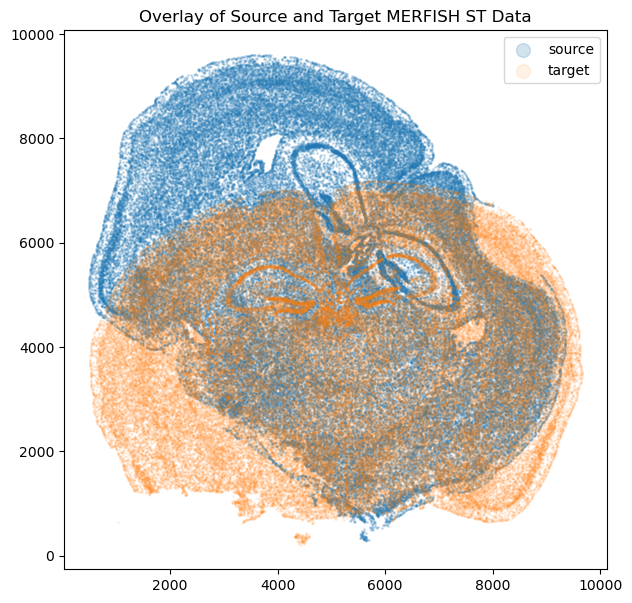

In [9]:
# STalign only needs cell centroid info, pull this 
xI = np.array(source_metadata['center_x'])
yI = np.array(source_metadata['center_y'])

xJ = np.array(target_metadata['center_x'])
yJ = np.array(target_metadata['center_y'])

# Plot 
fig,ax=plt.subplots(figsize=(7,7))
ax.scatter(xI, yI, s=1,alpha=0.2, label='source')
ax.scatter(xJ, yJ, s=1,alpha=0.1, label='target')
ax.legend(markerscale=10)
plt.title("Overlay of Source and Target MERFISH ST Data")

In [10]:
source_ad = ad.AnnData(np.array(source_gexp))
source_ad.var_names = np.array(source_gexp.columns)
source_ad.obs_names = source_gexp.index
source_ad.obsm['spatial'] = np.array([[xI[i], yI[i]] for i in range(len(xI))])

target_ad = ad.AnnData(np.array(target_gexp))
target_ad.var_names = np.array(target_gexp.columns) 
target_ad.obs_names = target_gexp.index 
target_ad.obsm['spatial'] = np.array([[xJ[i], yJ[i]] for i in range(len(xJ))])

In [11]:
#((85958, 649), (84172, 649))
source_ad.shape, target_ad.shape

((84172, 649), (85958, 649))

### 02. Preprocess ST gexp data using Scanpy.

In [12]:
sc.pp.filter_cells(target_ad, min_genes=100)
sc.pp.filter_genes(target_ad, min_cells=3)
sc.pp.filter_cells(source_ad, min_genes=100)
sc.pp.filter_genes(source_ad, min_cells=3)

source_ad.X = source_ad.X.astype(np.float64)
target_ad.X = target_ad.X.astype(np.float64)

sc.pp.normalize_total(source_ad, target_sum=1e4)
sc.pp.log1p(source_ad)

sc.pp.normalize_total(target_ad, target_sum=1e4)
sc.pp.log1p(target_ad)

# calculate highly variable genes (HVGs)
sc.pp.highly_variable_genes(source_ad)
sc.pp.highly_variable_genes(target_ad)

# extract top 500 variable genes for source and target 
genes_tI = np.array(source_ad.var['highly_variable'][source_ad.var['highly_variable']==True][0:500].index.values)
genes_tJ = np.array(target_ad.var['highly_variable'][target_ad.var['highly_variable']==True][0:500].index.values)

# find intersecting highly variable genes (85 total) 
genes_int = np.intersect1d(genes_tI, genes_tJ)

dfI = pd.DataFrame(source_ad.X, columns=source_ad.var.index)
dfJ = pd.DataFrame(target_ad.X, columns=target_ad.var.index)

indicesI = [index for index, value in enumerate(source_ad.var.index) if value in genes_int]
indicesJ = [index for index, value in enumerate(target_ad.var.index) if value in genes_int]

# subsetted dataframe of gene exp data (cells by genes) 
GI = dfI.iloc[:,indicesI]
GJ = dfJ.iloc[:,indicesJ]

# get list of length 2 for x and y coords 
list_I = [source_ad.obsm['spatial'][:,0],source_ad.obsm['spatial'][:,1]]
list_J = [target_ad.obsm['spatial'][:,0],target_ad.obsm['spatial'][:,1]]

### 0.3.1 Rasterize by cell density first.

In [83]:
X, Y, XctI = rasterize(list_I[0], list_I[1]) # Xct cell type density images 
X, Y, XctJ = rasterize(list_J[0], list_J[1])

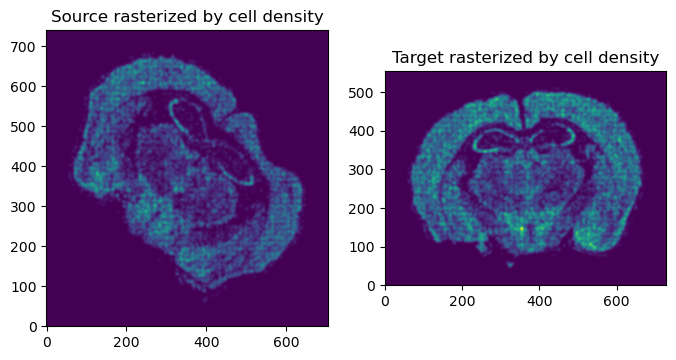

In [90]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].imshow(XctI[0], vmax = 0.5)
ax[0].set_title("Source rasterized by cell density")
ax[1].imshow(XctJ[0], vmax = 0.5)
ax[1].set_title("Target rasterized by cell density")
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()

### 03.2 Rasterize each gene into a 2D image. 
Using the intersecting HVGs from I and J, take the cell x gene matrix 'G' and rasterize each gene column into a smooth 2D image using the `rasterizeByGene()` function. Returns both the 3D raster stack and flattened feature vectors. 

In [13]:
GI.head() # stores the gene expression for each cell (row) by gene (column) 

Htr5b  Adora3  Adgre4    Adgrf5    Adgrl4     Brs3  Ccr1  Ccr7  Ccr9  \
0    0.0     0.0     0.0  4.413599  4.413599  2.85147   0.0   0.0   0.0   
1    0.0     0.0     0.0  0.000000  0.000000  0.00000   0.0   0.0   0.0   
2    0.0     0.0     0.0  0.000000  0.000000  0.00000   0.0   0.0   0.0   
3    0.0     0.0     0.0  0.000000  0.000000  0.00000   0.0   0.0   0.0   
4    0.0     0.0     0.0  5.070860  3.984724  0.00000   0.0   0.0   0.0   

      Ccrl2  ...  Pln     Csf1r    Fgfr4      Flt1  Insrr     Mertk      Musk  \
0  0.000000  ...  0.0  2.851470  2.85147  4.879050    0.0  4.879050  0.000000   
1  0.000000  ...  0.0  5.300466  0.00000  0.000000    0.0  4.612296  0.000000   
2  0.000000  ...  0.0  0.000000  0.00000  0.000000    0.0  0.000000  0.000000   
3  0.000000  ...  0.0  4.348158  0.00000  3.667859    0.0  5.034819  0.000000   
4  3.984724  ...  0.0  0.000000  0.00000  5.474231    0.0  4.383971  3.310004   

   Ntrk1    Pdgfrb       Tek  
0    0.0  4.193479  3.515312  
1    0.0  0.000000  0.000000  
2    0.0  0.000000  0.000000  
3    0.0  4.749304  0.000000  
4    0.0  4.383971  4.383971  

[5 rows x 85 columns]

Parameters from the original STalign framework: 
- dx = 30 
- blur = 1.5 

I used dx=15, to get more defined image (pixelated). 

In [91]:
# Rasterize all genes 
XgI, Y, XI, YI = rasterizeByGene(list_I[0], # x coordinates of cells in Dataset I 
                                   list_I[1], # y coordinates of cells in Dataset I
                                   GI, # cell by gene matrix for Dataset I 
                                   dx=15, 
                                   blur=1.5)

0 out of 85 genes rasterized.
10 out of 85 genes rasterized.
20 out of 85 genes rasterized.
30 out of 85 genes rasterized.
40 out of 85 genes rasterized.
50 out of 85 genes rasterized.
60 out of 85 genes rasterized.
70 out of 85 genes rasterized.
80 out of 85 genes rasterized.


In [93]:
Y.shape # genes by (x * y)

(85, 522405)

In [92]:
XgI[0].shape

(741, 705)

What `rasterizeByGene()` returns: 
- `XgI`: 3D tensor of rasterized gene images
    
    Shape: (n_genes, nrows, ncols) 
    
    The full rasterized spatial gene-expression image stack, where each slice is one gene. 
- `YgI`: flattened, mean-centered version of XgJ 
    
    Shape: (n_genes, nrows * ncols) 

    Same as: YgJ[i] = XgJ[i].ravel() - XgJ[i].mean()
- `XI`: raster grid's X-axis coordinates 
- `YI`: raster grid's Y-axis coordinates 

In [40]:
len(list_J[0]), len(list_I[0])

(26857, 19826)

In [94]:
XgJ, Y, XJ, YJ = rasterizeByGene(list_J[0], 
                                   list_J[1], 
                                   GJ, 
                                   dx=15, 
                                   blur=1.5)

0 out of 85 genes rasterized.
10 out of 85 genes rasterized.
20 out of 85 genes rasterized.
30 out of 85 genes rasterized.
40 out of 85 genes rasterized.
50 out of 85 genes rasterized.
60 out of 85 genes rasterized.
70 out of 85 genes rasterized.
80 out of 85 genes rasterized.


In [96]:
XctI.shape

(1, 741, 705)

In [97]:
dfI.shape, dfJ.shape

((19826, 649), (26857, 649))

In [98]:
GI.shape, GJ.shape

((19826, 85), (26857, 85))

In [99]:
len(XJ), len(YJ), len(XI), len(YI)

(729, 555, 705, 741)

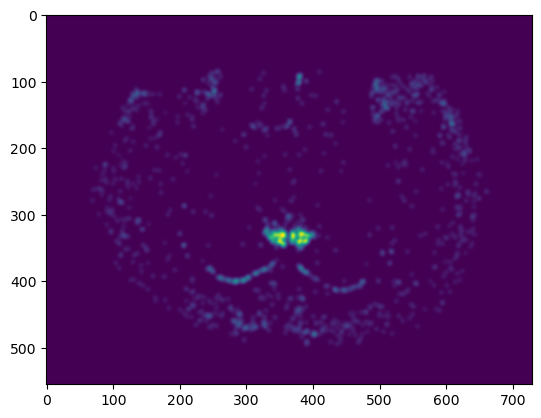

In [100]:
plt.imshow(XgJ[0])

Text(0.5, 1.0, 'Rasterized Target Image, J')

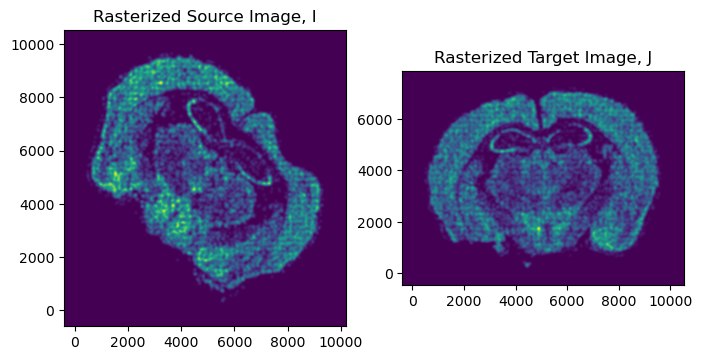

In [101]:
# plot rasterized images next to each other 
# get extent of images 
extentI = extent_from_x((YI,XI))
extentJ = extent_from_x((YJ,XJ))

# plot rasterized images 
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0].imshow(XgI[0], extent=extentI)
# ax[1].imshow(XgJ[0], extent=extentJ)
ax[0].imshow(XctI[0], extent=extentI)
ax[1].imshow(XctJ[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Rasterized Source Image, I")
ax[1].set_title("Rasterized Target Image, J")

In [102]:
GJ.columns == GI.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
gene_names = GI.columns  # or GJ.columns; they should match

n_genes = len(XgI)

for i in range(n_genes):
    print(f"{i}: {gene_names[i]}")
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(XgI[i])
    ax[0].set_title(f"{gene_names[i]} (Image I)")
    
    ax[1].imshow(XgJ[i])
    ax[1].set_title(f"{gene_names[i]} (Image J)")
    
    plt.show()

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_851/1007141319.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(source_ad, color='Gpr151', spot_size=75)


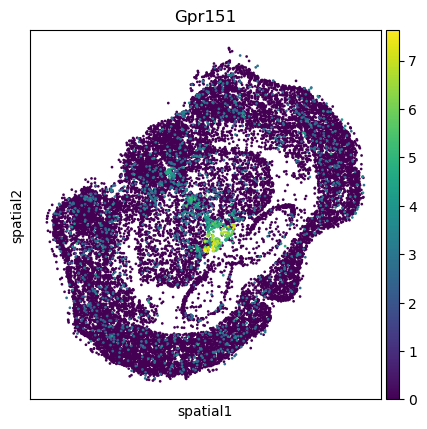

In [29]:
sc.pl.spatial(source_ad, color='Gpr151', spot_size=75)

In [30]:
gene_candidates = [17, 27, 33, 37, 42, 44, 49, 51, 54, 58, 75, 80]

17: Cckar


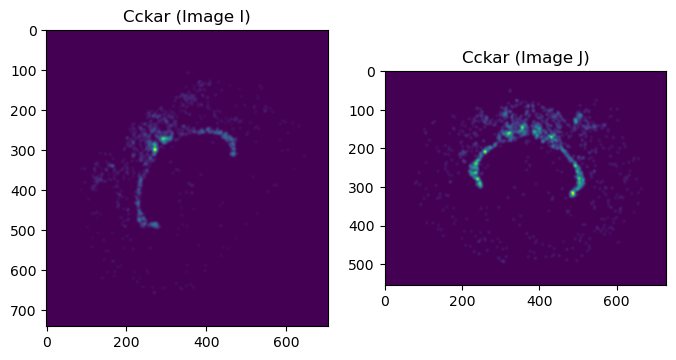

27: Glp2r


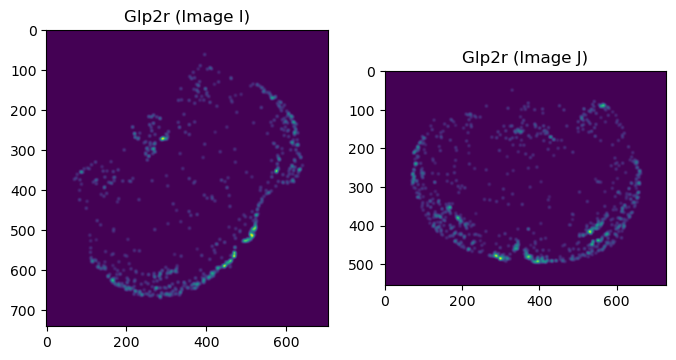

33: Tacr3


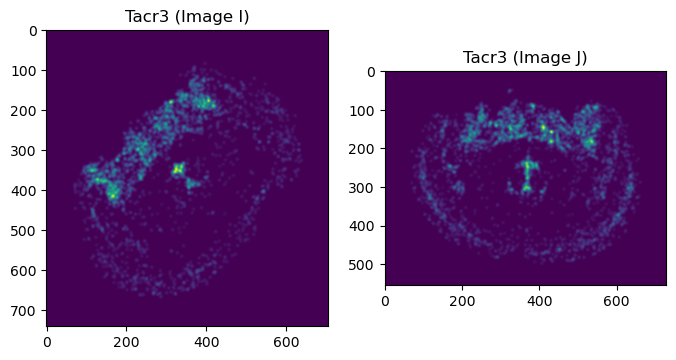

37: Npy2r


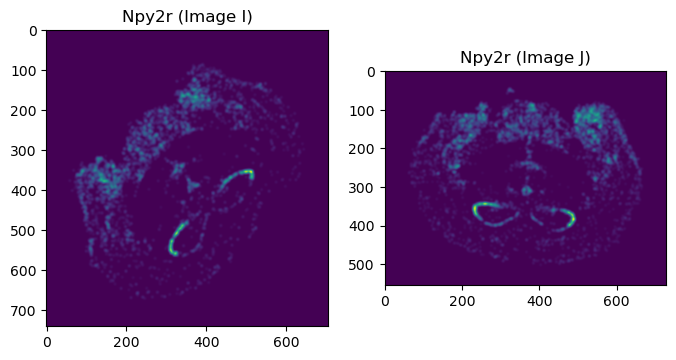

42: Gpr151


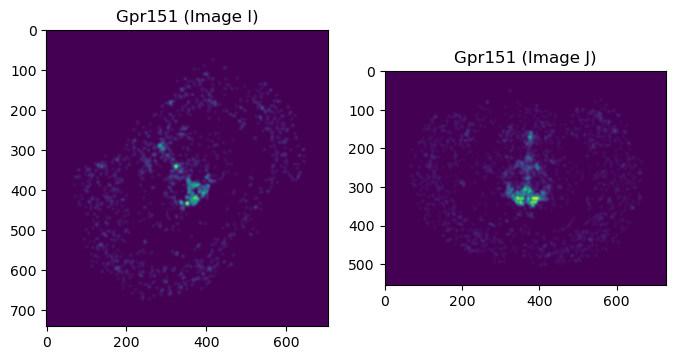

44: Prokr2


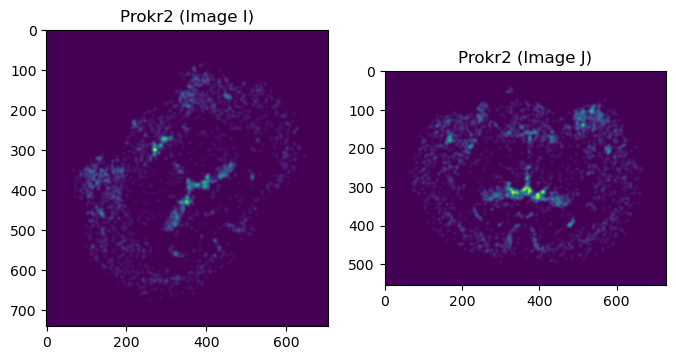

49: Rxfp2


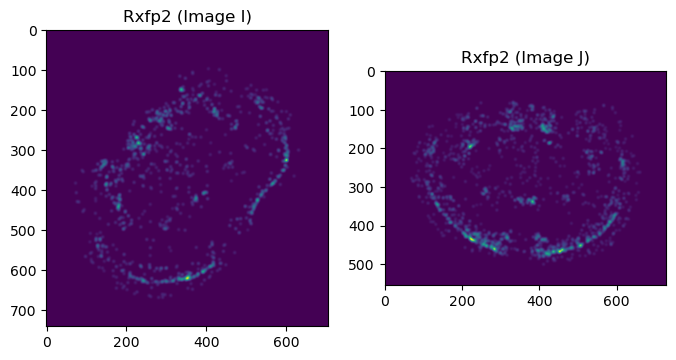

51: Tacr1


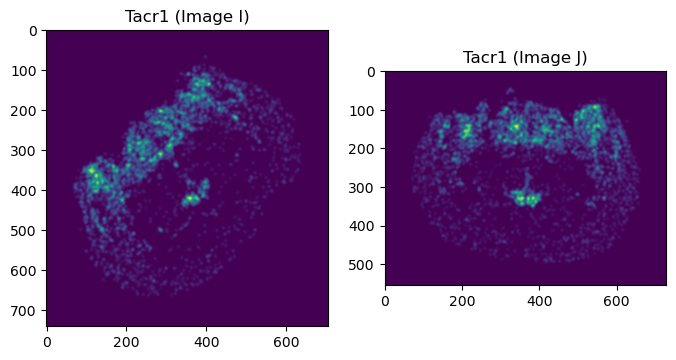

54: Gpr17


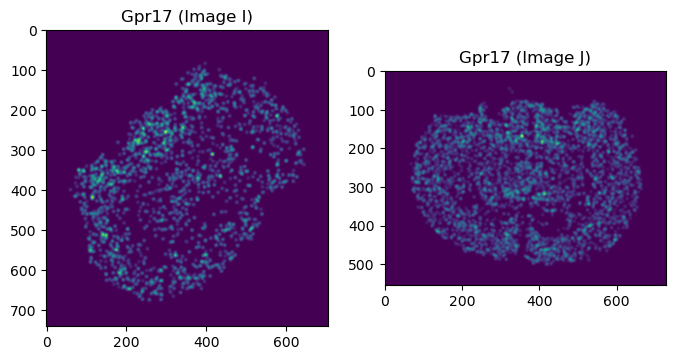

58: Aqp4


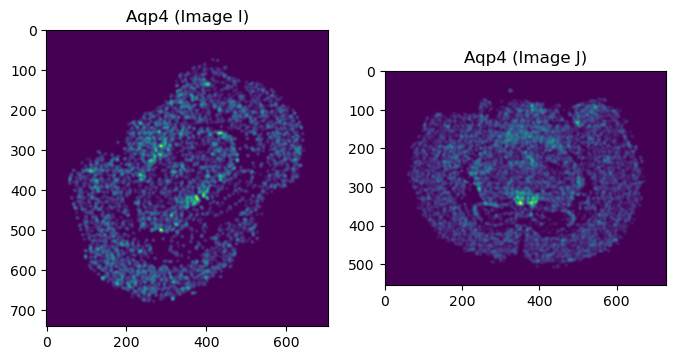

75: Pln


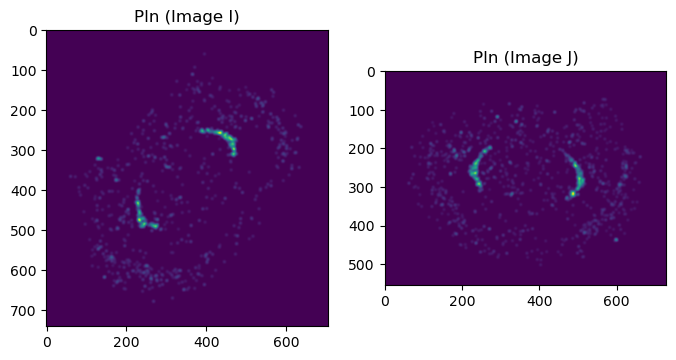

80: Mertk


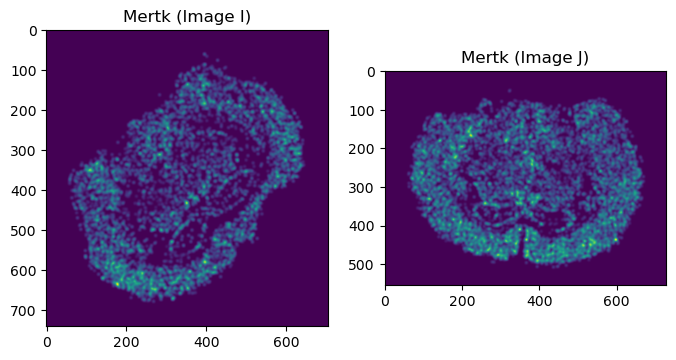

In [31]:
for i in gene_candidates:
    print(f"{i}: {gene_names[i]}")
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(XgI[i])
    ax[0].set_title(f"{gene_names[i]} (Image I)")
    
    ax[1].imshow(XgJ[i])
    ax[1].set_title(f"{gene_names[i]} (Image J)")
    
    plt.show()

### 04. Automate edge-based landmark selection
Automatically select N edge landmarks. 

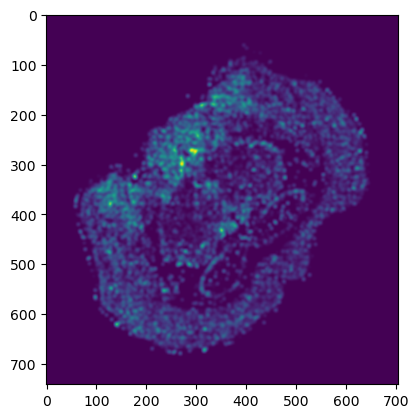

In [107]:
imgI = np.mean(XgI,axis=0)
plt.imshow(imgI, cmap='viridis')

In [108]:
gene_candidates

[17, 27, 33, 37, 42, 44, 49, 51, 54, 58, 75, 80]

In [110]:
# Select candidate genes
XgI_subset = XgI[gene_candidates]
XgJ_subset = XgJ[gene_candidates]

In [111]:
XgI_subset.shape, XgJ_subset.shape

((12, 741, 705), (12, 555, 729))

In [112]:
# Save
np.save("XgI.npy", XgI)
np.save("XgJ.npy", XgJ)

# Load
XgI = np.load("XgI.npy")
XgJ = np.load("XgJ.npy")


In [113]:
XgI.shape, XgJ.shape

((85, 741, 705), (85, 555, 729))

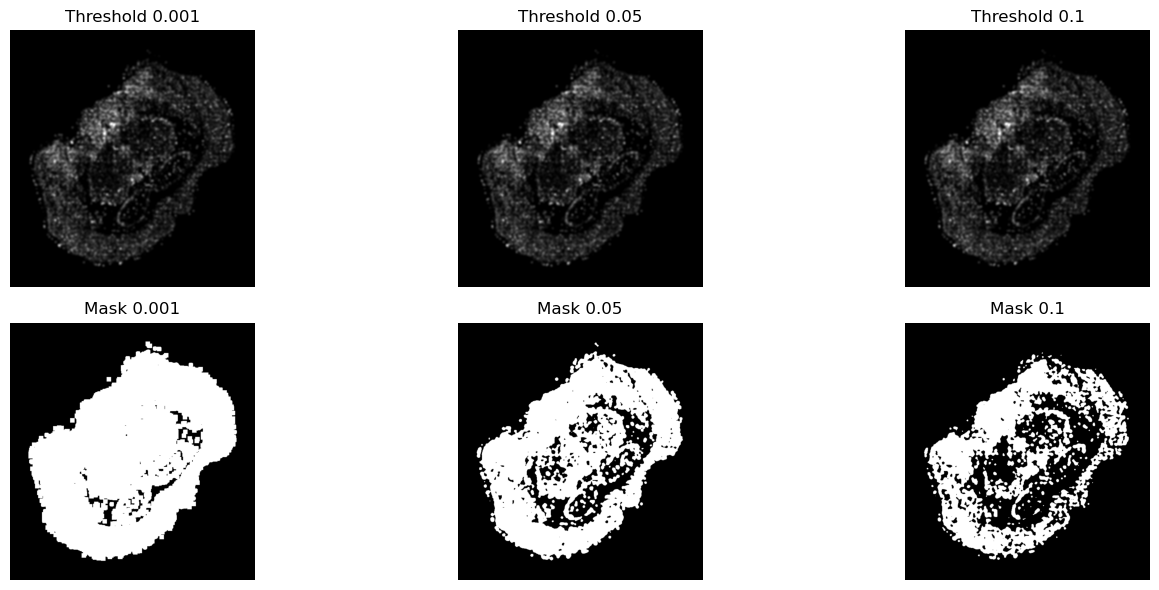

In [114]:
import numpy as np
import matplotlib.pyplot as plt

img = np.mean(XgI, axis=0)

# Define thresholds to visualize
thresholds = [0.001, 0.05, 0.1]

fig, axs = plt.subplots(2, len(thresholds), figsize=(15, 6))

for i, t in enumerate(thresholds):
    # Compute mask
    mask = (img > t * img.max()).astype(np.uint8)
    
    # Show original image
    axs[0, i].imshow(img, cmap='gray')
    axs[0, i].set_title(f"Threshold {t}")
    axs[0, i].axis('off')
    
    # Show mask
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].set_title(f"Mask {t}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [115]:
import numpy as np
import cv2

def get_edge_landmarks(Xg, n_points=20, threshold=0.01):
    """
    Extract n evenly-spaced points from the tissue edge.
    Xg: 3D tensor array of (n_genes, n_rows, n_cols)
    n_points: number of landmarks
    threshold: used to create a binary mask (tune for your dataset)
    """
    print(f"Selecting {n_points} landmark points at threshold {threshold}...")

    # 0. Normalize the image 
    img = np.mean(Xg, axis=0)

    # 1. Binary mask of tissue
    mask = (img > threshold * img.max()).astype(np.uint8)

    # 2. Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) == 0:
        raise ValueError("No tissue detected—adjust threshold.")

    # 3. Pick the largest contour
    contour = max(contours, key=cv2.contourArea)
    contour = contour[:, 0, :]  # shape (K, 2)

    # 4. Compute cumulative distances along contour
    diffs = np.diff(contour, axis=0)
    dists = np.sqrt((diffs**2).sum(axis=1))
    cumdist = np.insert(np.cumsum(dists), 0, 0)

    # 5. Interpolate n evenly-spaced points
    target_distances = np.linspace(0, cumdist[-1], n_points)
    sampled = []
    for td in target_distances:
        idx = np.searchsorted(cumdist, td)
        idx = min(idx, len(contour)-1)
        sampled.append(contour[idx])

    sampled = np.array(sampled)
    print("Returning sampled points...")
    return sampled

In [116]:
def visualize_points(XgI, XgJ, pointsI, pointsJ): 
    """
    Display source and target images with landmarks.

    Parameters
    ----------
    XgI, XgJ : np.ndarray (a 3D tensor)
        Rasterized images (n_genes, nrows, ncols)
    pointsI, pointsJ : np.ndarray
        Landmark coordinates in (row, col) format
    """
    # pointsI and pointsJ are the landmarks from get_edge_landmarks
    imgI = np.mean(XgI, axis=0)
    imgJ = np.mean(XgJ, axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for XgI
    axs[0].imshow(imgI, cmap='gray')
    axs[0].scatter(pointsI[:, 0], pointsI[:, 1], c='red', s=40)
    axs[0].set_title('Landmarks on XgI')
    axs[0].axis('off')

    # Plot for XgJ
    axs[1].imshow(imgJ, cmap='gray')
    axs[1].scatter(pointsJ[:, 0], pointsJ[:, 1], c='red', s=40)
    axs[1].set_title('Landmarks on XgJ')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

Selecting 20 landmark points at threshold 0.01...
Returning sampled points...
Selecting 20 landmark points at threshold 0.01...
Returning sampled points...


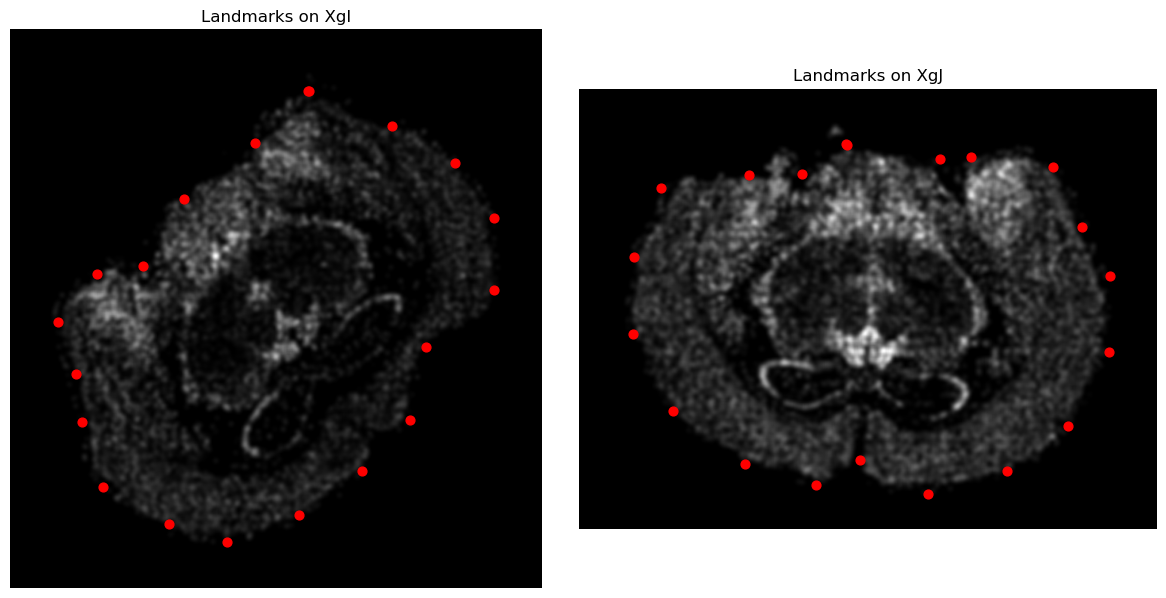

In [124]:
source_pts = get_edge_landmarks(XgI_subset, n_points=20, threshold=0.01)
target_pts = get_edge_landmarks(XgJ_subset, n_points=20, threshold=0.01)

#print(source_pts.shape, target_pts.shape)
visualize_points(XgI_subset, XgJ_subset, source_pts, target_pts)

In [125]:
source_pts, target_pts

(array([[395,  81],
        [324, 150],
        [231, 224],
        [176, 313],
        [115, 324],
        [ 63, 387],
        [ 87, 456],
        [ 95, 520],
        [123, 606],
        [210, 656],
        [288, 679],
        [383, 644],
        [467, 585],
        [530, 518],
        [552, 421],
        [642, 345],
        [642, 249],
        [590, 176],
        [506, 128],
        [396,  81]], dtype=int32),
 array([[336,  69],
        [280, 107],
        [213, 108],
        [103, 125],
        [ 68, 212],
        [ 67, 309],
        [117, 406],
        [209, 473],
        [298, 500],
        [354, 468],
        [440, 511],
        [539, 482],
        [616, 425],
        [668, 332],
        [669, 236],
        [634, 174],
        [597,  98],
        [494,  86],
        [455,  88],
        [337,  70]], dtype=int32))

In [126]:
# Compute L and T
L, T = L_T_from_points(source_pts, target_pts)
print("Linear matrix L:\n", L)
print("Translation vector T:\n", T)

Linear matrix L:
 [[ 1.05915824  0.45645752]
 [-0.14446216  0.76958697]]
Translation vector T:
 [-158.36112533   22.92575717]


In [127]:
A = to_A(torch.tensor(L),torch.tensor(T))

In [128]:
A

tensor([[ 1.0592e+00,  4.5646e-01, -1.5836e+02],
        [-1.4446e-01,  7.6959e-01,  2.2926e+01],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)

In [129]:
XctI = (XctI - np.min(XctI))/(np.max(XctI)-np.min(XctI))
XctJ = (XctJ - np.min(XctJ))/(np.max(XctJ)-np.min(XctJ))

XgI = (XgI - np.min(XgI))/(np.max(XgI)-np.min(XgI))
XgJ = (XgJ - np.min(XgJ))/(np.max(XgJ)-np.min(XgJ))

In [130]:
XctI.shape, XctJ.shape, XgI.shape, XgJ.shape

((1, 741, 705), (1, 555, 729), (85, 741, 705), (85, 555, 729))

### 0.5 Run LDDMM 

Modified LDDMM function using gene expression only, got rid of cell density part 

In [131]:
def LDDMM(xI,I,xJ,J,Ig, Jg, pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaMg=1.0, sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
 
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    Jg = torch.tensor(Jg,device=device,dtype=dtype)
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand # WHY DO IT THIS WAY??
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)] # "a" determines step size of velocity field
        XV = torch.stack(torch.meshgrid(xv),-1) #creating a meshgrid to apply transformation to all points in a grid (creating the 'field' in velocity field)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True) # why does XW have a shape of 3 (aren't there only x and y points? 2D)
        #velocity field start out as a zero vector field - how does it get updated? 
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv) #for plotting purposes
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype) #step in between each set of points
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)] # 5 dimensions of grid of XV/dv - should be similar to XV but not a meshgrid, just points along each axis
    extentF = extent_from_x(fv) #plotting
    FV = torch.stack(torch.meshgrid(fv),-1) # would this not just be the same as XV? print out both and compare 
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0) #smoothing kernel? what is this?

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    

    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,5)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass


    
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
        #print(Xs.shape)
        # transform image
        #AI = interp(xI,I.swapaxes(1,2),Xs.permute(2,1,0),padding_mode="border")
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")
        AIg = interp(xI,Ig,Xs.permute(2,0,1),padding_mode="border")
        #AI = AI.permute(0,2,1)
        #print(AI.shape)
        #print(J.shape)
        if it == 0:
            AI_orig = AIg.clone().detach()
        # objective function
        EMg = torch.sum((AIg - Jg)**2*WM)/2.0/sigmaMg**2
        
        EM = torch.sum((AI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER + EMg
        tosave = [E.item(), EM.item(), ER.item(), EMg.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.9




        # draw
        if not it%10:
            AI_plt = AIg
            J_plt = Jg
            #print(AI.shape)
            if AI.shape[0]>=1:
                AI_plt = torch.mean(AIg, 0)
                AI_plt = torch.unsqueeze(AI_plt, 0)
                AI_orig = torch.mean(AI_orig, 0)
                AI_orig = torch.unsqueeze(AI_orig, 0)
                J_plt = torch.mean(Jg, 0)
                J_plt = torch.unsqueeze(J_plt, 0)
            #print(AI_plt.shape)
            ax[0].cla()
            ax[0].imshow(   ((AI_orig-torch.amin(AI_orig,(1,2))[...,None,None])/(torch.amax(AI_orig,(1,2))-torch.amin(AI_orig,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')
            
            ax[1].cla()
            ax[1].imshow(   ((AI_plt-torch.amin(AI_plt,(1,2))[...,None,None])/(torch.amax(AI_plt,(1,2))-torch.amin(AI_plt,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('space tformed source')
            
            ax[4].cla()
            ax[4].imshow(clip( (AI_plt - J_plt)/(torch.max(Jg).item())*3.0  ).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
            ax[4].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[4].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[4].set_title('Error')

            ax[2].cla()
            ax[2].imshow(J_plt.permute(1,2,0).cpu()/torch.max(Jg).item(),extent=extentJ)
            ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')


            toshow = v[0].clone().detach().cpu()
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow),extent=extentV)
            ax[3].set_title('velocity')
            

            Esave_array = np.array(Esave)  # shape: (niter_done, n_components)

            # Compute per-iteration delta
            delta = np.diff(Esave_array, axis=0)  # shape: (niter_done-1, n_components)
            delta = np.vstack([np.zeros((1,Esave_array.shape[1])), delta])  # prepend 0 for first iteration
            
            labels = ['E', 'EM', 'ER', 'EMg', 'EP']
            
            for i in range(len(labels)):
                axE[i].cla()
                axE[i].plot([e[i] for e in Esave], label=f'{labels[i]}')
                axE[i].set_yscale('log')
                
                # Annotate the last delta on the plot
                axE[i].text(0.95, 0.95, f'Δ={delta[-1,i]:.3e}', 
                             transform=axE[i].transAxes,
                             horizontalalignment='right', verticalalignment='top',
                             fontsize=9, color='red')
                
                axE[i].legend([labels[i]])

            fig.canvas.draw()
            figE.canvas.draw()
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        "AI_plt": AI_plt.clone().detach(),
        "AI": AI.clone().detach(),
        "J": J.clone().detach()
    }

In [141]:
def LDDMM_gene_only(xI, Ig, xJ, Jg, L=None, T=None, A=None, v=None, xv=None,
                    a=500.0, p=2.0, expand=2.0, nt=3, niter=5000,
                    diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
                    sigmaMg=1.0, sigmaR=5e5,
                    device='cpu', dtype=torch.float64):
    """
    LDDMM alignment using only gene expression (EMg).
    """

    # convert grids to tensors if needed
    xI = [torch.as_tensor(x, device=device, dtype=dtype) for x in xI]
    xJ = [torch.as_tensor(x, device=device, dtype=dtype) for x in xJ]

    # convert images
    Ig = torch.as_tensor(Ig, device=device, dtype=dtype)
    Jg = torch.as_tensor(Jg, device=device, dtype=dtype)

    # ------------------------------
    # Initialize affine transform
    # ------------------------------
    if A is not None:
        if L is not None or T is not None:
            raise Exception('If specifying A, must not specify L or T')
        L = torch.tensor(A[:2,:2], device=device, dtype=dtype, requires_grad=True)
        T = torch.tensor(A[:2,-1], device=device, dtype=dtype, requires_grad=True)
    else:
        if L is None: L = torch.eye(2, device=device, dtype=dtype, requires_grad=True)
        if T is None: T = torch.zeros(2, device=device, dtype=dtype, requires_grad=True)

    L = torch.tensor(L, device=device, dtype=dtype, requires_grad=True)
    T = torch.tensor(T, device=device, dtype=dtype, requires_grad=True)

    # Convert images to torch
    Ig = torch.tensor(Ig, device=device, dtype=dtype)
    Jg = torch.tensor(Jg, device=device, dtype=dtype)

    # ------------------------------
    # Initialize velocity field
    # ------------------------------
    if v is not None and xv is not None:
        v = torch.tensor(v, device=device, dtype=dtype, requires_grad=True)
        xv = [torch.tensor(x, device=device, dtype=dtype) for x in xv]
        nt = v.shape[0]
    else:
        minv = torch.as_tensor([x[0] for x in xI], device=device, dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI], device=device, dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0], device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5, device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]), device=device, dtype=dtype, requires_grad=True)

    # Smoothing kernel
    dv = torch.as_tensor([x[1]-x[0] for x in xv], device=device, dtype=dtype)
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(v.shape[1:],dv)]
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)
    K = 1.0/LL
    DV = torch.prod(dv)

    # ------------------------------
    # Iterations
    # ------------------------------
    Esave = []
    for it in range(niter):
        # Affine
        A = to_A(L,T)
        Ai = torch.linalg.inv(A)

        # Transform image grid
        XI = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
        Xs = (Ai[:2,:2]@XI[...,None])[...,0] + Ai[:2,-1]
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt

        # Interpolate gene expression
        AIg = interp(xI, Ig, Xs.permute(2,0,1), padding_mode="border")

        # Objective: gene expression only
        EMg = torch.sum((AIg - Jg)**2)/2.0/sigmaMg**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EMg + ER

        Esave.append([E.item(), EMg.item(), ER.item()])

        # Backprop
        E.backward()
        with torch.no_grad():
            L -= epL*L.grad
            T -= epT*T.grad
            L.grad.zero_(); T.grad.zero_()
            vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it>=diffeo_start: v -= epV*vgrad
            v.grad.zero_()

    # Compute delta energy per component
    Esave_array = np.array(Esave)
    deltaE = np.diff(Esave_array, axis=0)
    deltaE = np.vstack([np.zeros((1,Esave_array.shape[1])), deltaE])

    return {
        'A': A.clone().detach(), # final affine transformation matrix 
        'v': v.clone().detach(), # velocity fields 
        'xv': xv, # spatial grid of velocity field
        'Esave': Esave_array, # energy at every iteration 
        'deltaE': deltaE
    }

In [143]:
Ig = XgI[gene_candidates, :, :]

In [144]:
Ig.shape

(12, 741, 705)

In [169]:
params = {
    'niter': 200,
    'a': 250,
    # 'pointsI': source_pts,
    # 'pointsJ': target_pts,
    # 'sigmaM': 0.25,
    'sigmaMg': 0.25,
    'A': A,
}


# Selecting spatially distinct genes
out_cell_g = LDDMM_gene_only(
    xI=[YI, XI], 
    xJ=[YJ, XJ], 
    Ig=XgI[gene_candidates, :, :],
    Jg=XgJ[gene_candidates, :, :],
    **params
)

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_851/2819785841.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2], device=device, dtype=dtype, requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_851/2819785841.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1], device=device, dtype=dtype, requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_851/2819785841.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

In [195]:
deltaE = out_cell_g['deltaE']

In [200]:
Esave = out_cell_g['Esave']

In [180]:
np.sum(Esave[0])

237778.2874782106

In [181]:
np.sum(Esave[1])

236598.44698043226

Text(0.5, 1.0, 'ER across 200 iterations with a = 250')

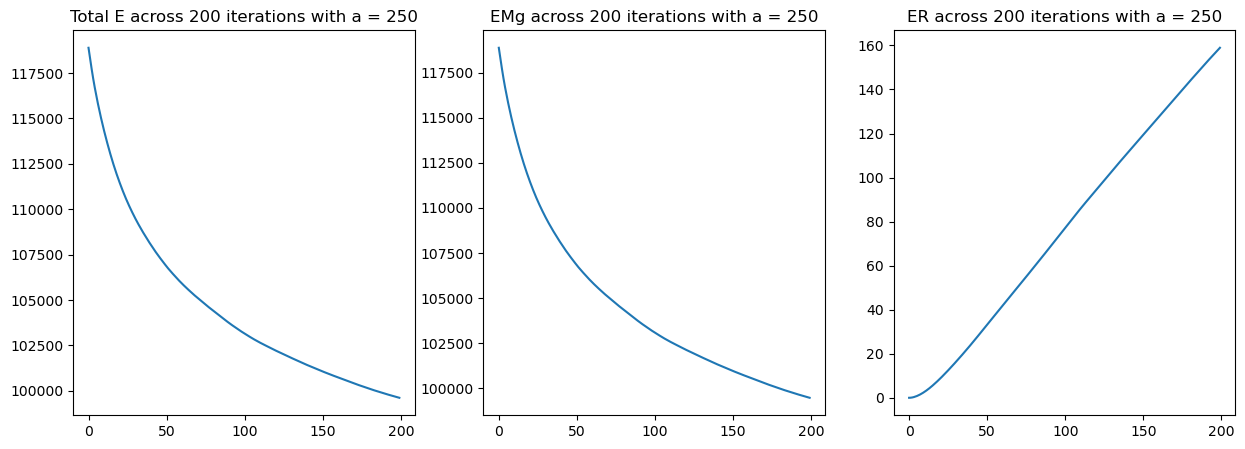

In [196]:
# Esave saves total, EMg, and ER 
n_iter = 200 
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(Esave[:,0]) 
ax[0].set_title(f"Total E across {n_iter} iterations with a = 250")
ax[1].plot(Esave[:,1]) 
ax[1].set_title(f"EMg across {n_iter} iterations with a = 250")
ax[2].plot(Esave[:,2]) 
ax[2].set_title(f"ER across {n_iter} iterations with a = 250")

In [201]:
total_E_version0 = Esave[:,0]

In [207]:
delta_total_E_version0 = total_E_version0[0] - total_E_version0[-1] 

In [208]:
delta_total_E_version0 

19267.222300969297

In [197]:
params = {
    'niter': 200,
    'a': 200,
    # 'pointsI': source_pts,
    # 'pointsJ': target_pts,
    # 'sigmaM': 0.25,
    'sigmaMg': 0.25,
    'A': A,
}


# Selecting spatially distinct genes
out_cell_g1 = LDDMM_gene_only(
    xI=[YI, XI], 
    xJ=[YJ, XJ], 
    Ig=XgI[gene_candidates, :, :],
    Jg=XgJ[gene_candidates, :, :],
    **params
)

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_851/2819785841.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2], device=device, dtype=dtype, requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_851/2819785841.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1], device=device, dtype=dtype, requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_851/2819785841.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

Text(0.5, 1.0, 'ER across 200 iterations with a = 250')

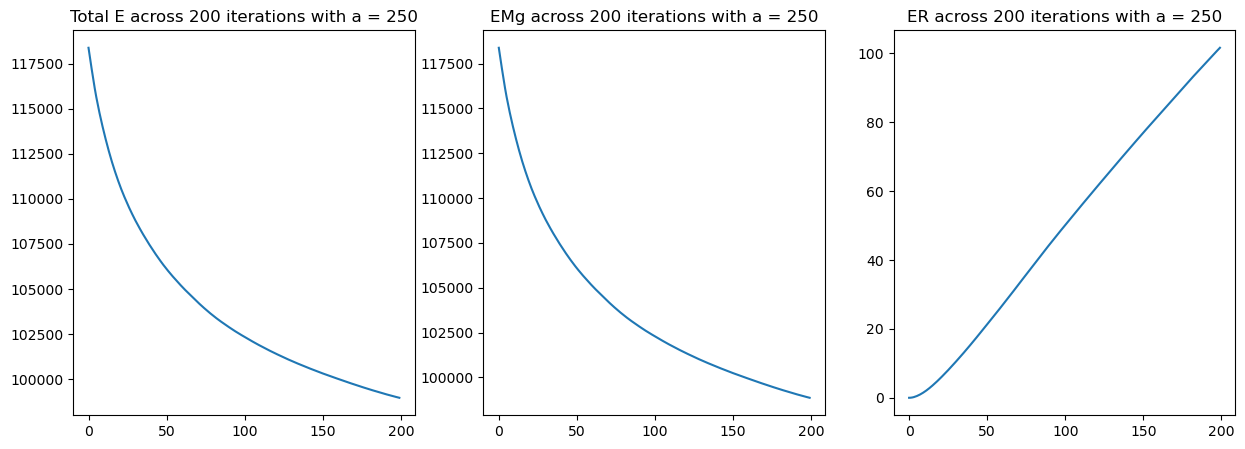

In [198]:
Esave = out_cell_g1['Esave']
# Esave saves total, EMg, and ER 
n_iter = 200 
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(Esave[:,0]) 
ax[0].set_title(f"Total E across {n_iter} iterations with a = 200")
ax[1].plot(Esave[:,1]) 
ax[1].set_title(f"EMg across {n_iter} iterations with a = 200")
ax[2].plot(Esave[:,2]) 
ax[2].set_title(f"ER across {n_iter} iterations with a = 200")

In [209]:
Esave_v1 = out_cell_g1['Esave']
total_E_version1 = Esave_v1[:,0]
delta_total_E_version1 = total_E_version1[0] - total_E_version1[-1] 
delta_total_E_version1

19416.727936577343

In [210]:
total_E_version1[-1]

98964.29892899393

In [211]:
total_E_version0[-1]

99621.921438136

In [222]:
def warp_points_with_lddmm(points, A, v, xv):
    """
    Warp arbitrary scattered points using affine + LDDMM velocity field.
    points : N×2 (row, col)
    A : 3×3 affine
    v : nt×H×W×2
    xv = [y_coords, x_coords]
    """
    import torch

    device = v.device
    dtype = v.dtype

    pts = torch.as_tensor(points, dtype=dtype, device=device)

    # ----------------------------------------------------
    # Apply affine transform
    # ----------------------------------------------------
    L = A[:2, :2]
    T = A[:2, 2]
    pts = pts @ L.T + T    # N×2

    # ----------------------------------------------------
    # Velocity interpolation (bilinear)
    # ----------------------------------------------------
    y_grid, x_grid = xv    # 1D tensors
    nt, H, W, _ = v.shape

    for t in range(nt):
        vx_field = v[t]    # H×W×2

        # Extract coords
        ys = pts[:, 0]
        xs = pts[:, 1]

        # Compute fractional indices
        iy = (ys - y_grid[0]) / (y_grid[1] - y_grid[0])
        ix = (xs - x_grid[0]) / (x_grid[1] - x_grid[0])

        # Floor / ceil
        iy0 = torch.clamp(iy.floor().long(), 0, H-2)
        ix0 = torch.clamp(ix.floor().long(), 0, W-2)
        iy1 = iy0 + 1
        ix1 = ix0 + 1

        # Bilinear weights
        wy = iy - iy0
        wx = ix - ix0

        # Sample
        v00 = vx_field[iy0, ix0]
        v01 = vx_field[iy0, ix1]
        v10 = vx_field[iy1, ix0]
        v11 = vx_field[iy1, ix1]

        vx = (
            (1-wy)[:,None] * ((1-wx)[:,None]*v00 + wx[:,None]*v01) +
            wy[:,None]     * ((1-wx)[:,None]*v10 + wx[:,None]*v11)
        )

        pts = pts + vx / nt

    return pts.cpu().numpy()

In [223]:
print(out_cell_g1['v'].shape)
print(out_cell_g1['v'][0].shape)

torch.Size([3, 222, 212, 2])
torch.Size([222, 212, 2])


In [230]:
A = out_cell_g1['A']
v = out_cell_g1['v']
xv = out_cell_g1['xv']

In [231]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], axis=1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

Text(0.5, 1.0, 'LDDMM only gene expression')

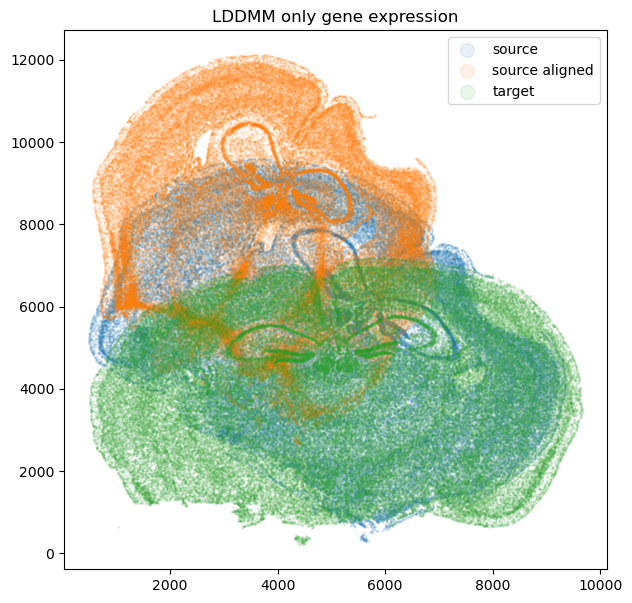

In [234]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("LDDMM only gene expression")

# Until here 

In [172]:
deltaE = out_cell_g['deltaE']
len(deltaE)

200

In [173]:
deltaE[-1]

array([-23.75697354, -24.52520889,   0.76823535])

In [174]:
A = out_cell_g['A']
v = out_cell_g['v']
xv = out_cell_g['xv']

In [175]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

Text(0.5, 1.0, 'LDDMM only gene expression')

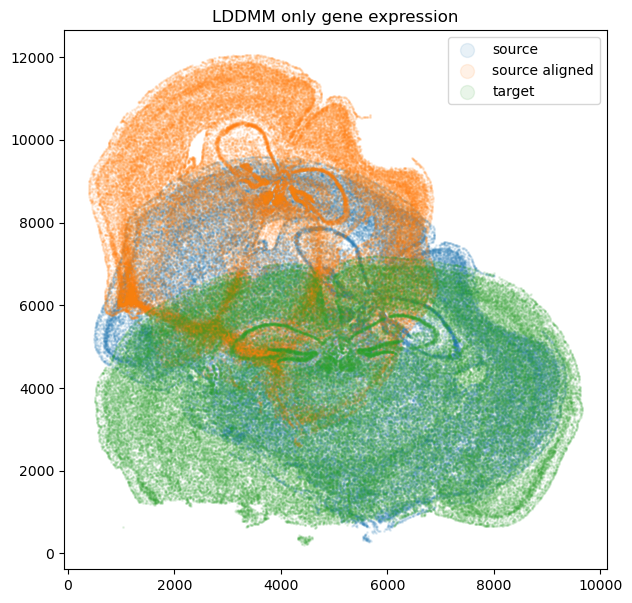

In [176]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("LDDMM only gene expression")

# until 

In [133]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def LDDMM_gene_only_plot(xI, I, xJ, J, Ig, Jg, pointsI=None, pointsJ=None,
                         L=None, T=None, A=None, v=None, xv=None,
                         a=500.0, p=2.0, expand=2.0, nt=3,
                         niter=5000, diffeo_start=0,
                         epL=2e-8, epT=2e-1, epV=2e3,
                         sigmaMg=1.0, sigmaR=5e5, sigmaP=2e1,
                         device='cpu', dtype=torch.float64,
                         plot_every=10):

    # --- Affine setup ---
    if A is not None:
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2], device=device, dtype=dtype, requires_grad=True)
        T = torch.tensor(A[:2,-1], device=device, dtype=dtype, requires_grad=True)
    else:
        if L is None: L = torch.eye(2, device=device, dtype=dtype, requires_grad=True)
        if T is None: T = torch.zeros(2, device=device, dtype=dtype, requires_grad=True)
    L = torch.tensor(L, device=device, dtype=dtype, requires_grad=True)
    T = torch.tensor(T, device=device, dtype=dtype, requires_grad=True)

    # --- Convert images ---
    I = torch.tensor(I, device=device, dtype=dtype)
    J = torch.tensor(J, device=device, dtype=dtype)
    Ig = torch.tensor(Ig, device=device, dtype=dtype)
    Jg = torch.tensor(Jg, device=device, dtype=dtype)

    # --- Velocity field setup ---
    if v is not None and xv is not None:
        v = torch.tensor(v, device=device, dtype=dtype, requires_grad=True)
        xv = [torch.tensor(x, device=device, dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv), -1)
        nt = v.shape[0]
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI], device=device, dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI], device=device, dtype=dtype)
        minv, maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0], device=device, dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m, M, a*0.5, device=device, dtype=dtype) for m, M in zip(minv, maxv)]
        XV = torch.stack(torch.meshgrid(xv), -1)
        v = torch.zeros((nt, XV.shape[0], XV.shape[1], XV.shape[2]), device=device, dtype=dtype, requires_grad=True)
    else:
        raise Exception('Must input both v and xv if initializing velocity')

    dv = torch.as_tensor([x[1]-x[0] for x in xv], device=device, dtype=dtype)
    FV = torch.stack(torch.meshgrid([torch.arange(n, device=device, dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]), -1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)
    K = 1.0/LL
    DV = torch.prod(dv)

    # --- Landmarks ---
    if pointsI is not None and pointsJ is not None:
        pointsI = torch.tensor(pointsI, device=device, dtype=dtype)
        pointsJ = torch.tensor(pointsJ, device=device, dtype=dtype)
    else:
        pointsI = torch.zeros((0,2), device=device, dtype=dtype)
        pointsJ = torch.zeros((0,2), device=device, dtype=dtype)

    xI = [torch.tensor(x, device=device, dtype=dtype) for x in xI]
    xJ = [torch.tensor(x, device=device, dtype=dtype) for x in xJ]

    Esave = []

    # --- Setup plots ---
    fig, ax = plt.subplots(2,3, figsize=(15,8))
    ax = ax.ravel()
    figE, axE = plt.subplots(1,4, figsize=(12,3))
    axE = axE.ravel()

    for it in range(niter):
        # --- Affine matrix ---
        A_mat = to_A(L, T)
        Ai = torch.linalg.inv(A_mat)

        # --- Transform sample points ---
        Xs = (Ai[:2,:2] @ XV[...,None])[...,0] + Ai[:2,-1]
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv, -v[t].permute(2,0,1), Xs.permute(2,0,1)).permute(1,2,0)/nt

        pointsIt = pointsI.clone()
        if pointsIt.shape[0]>0:
            for t in range(nt):
                pointsIt += interp(xv, v[t].permute(2,0,1), pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A_mat[:2,:2] @ pointsIt.T + A_mat[:2,-1][...,None]).T

        # --- Interpolate gene images ---
        AIg = interp(xI, Ig, Xs.permute(2,0,1), padding_mode="border")

        # --- Energy ---
        EMg = torch.sum((AIg - Jg)**2)/2.0/sigmaMg**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v, dim=(1,2)))**2, dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EMg + ER
        EP = torch.tensor(0.0)
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
        Esave.append([E.item(), EMg.item(), ER.item(), EP.item()])

        # --- Gradients ---
        E.backward()
        with torch.no_grad():
            L -= epL*L.grad
            T -= epT*T.grad
            L.grad.zero_()
            T.grad.zero_()

            vgrad = v.grad
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad, dim=(1,2))*K[...,None], dim=(1,2)).real
            if it >= diffeo_start:
                v -= epV*vgrad
            v.grad.zero_()

        # --- Plot every plot_every iterations ---
        if it % plot_every == 0 or it==niter-1:
            # Gene images
            AI_mean = torch.mean(AIg,0).unsqueeze(0)
            J_mean = torch.mean(Jg,0).unsqueeze(0)
            ax[0].cla()
            ax[0].imshow(AI_mean.permute(1,2,0).cpu(), cmap='viridis')
            ax[0].scatter(pointsIt[:,1].cpu(), pointsIt[:,0].cpu(), c='r')
            ax[0].set_title('Transformed source')

            ax[1].cla()
            ax[1].imshow(J_mean.permute(1,2,0).cpu(), cmap='viridis')
            ax[1].scatter(pointsJ[:,1].cpu(), pointsJ[:,0].cpu(), c='b')
            ax[1].set_title('Target')

            # Difference
            ax[2].cla()
            diff = (AI_mean - J_mean)
            ax[2].imshow(diff.permute(1,2,0).cpu(), cmap='bwr', vmin=-diff.max(), vmax=diff.max())
            ax[2].set_title('Difference')

            # Velocity
            ax[3].cla()
            v0 = v[0].clone()
            v0 /= v0.abs().max()
            ax[3].imshow(v0[...,0].cpu(), cmap='coolwarm')
            ax[3].set_title('Velocity field (x comp)')

            # Energy curves
            Esave_array = np.array(Esave)
            labels = ['Total E', 'EMg', 'ER', 'EP']
            for i in range(4):
                axE[i].cla()
                axE[i].plot(Esave_array[:,i], label=labels[i])
                axE[i].set_yscale('log')
                axE[i].legend()
            fig.canvas.draw()
            figE.canvas.draw()

    Esave_array = np.array(Esave)
    delta_E_total = Esave_array[-1,0] - Esave_array[0,0]

    return {
        'A': A_mat.clone().detach(),
        'v': v.clone().detach(),
        'xv': xv,
        'AIg': AIg.clone().detach(),
        'Esave': Esave_array,
        'delta_E_total': delta_E_total
    }

In [134]:
gene_candidates

[17, 27, 33, 37, 42, 44, 49, 51, 54, 58, 75, 80]

In [135]:
# gene_candidates contains indices of the genes you want to use
XgI_subset = XgI[gene_candidates, :, :]
XgJ_subset = XgJ[gene_candidates, :, :]

In [136]:
XgI_subset.shape, XgJ_subset.shape

((12, 741, 705), (12, 555, 729))

In [178]:
def rasterizeByGene(x, y, G, dx=15, blur=1.5, expand=1.2):
    """
    Rasterize each column of a cell by gene matrix into a 2D spatial grid.

    Returns both raw raster images and flattened, mean-centered forms,
    along with the 2D raster image for each gene (M).
    """
    nrows = 0
    ncols = 0
    Ms = []  # store M for each gene
    
    for i in range(G.shape[1]):
        g = np.array(G.iloc[:, i])
        
        # rasterize returns X-axis, Y-axis, rasterized image, optionally fig
        XI, YI, M = rasterize(x, y, g=g, dx=dx, blur=blur, expand=expand)
        
        if i == 0:
            # initialize arrays after knowing size
            nrows = YI.size
            ncols = XI.size
            X = np.empty([G.shape[1], nrows, ncols])
            Y = np.empty([G.shape[1], nrows * ncols])
        
        # store raw rasterized image
        X[i] = np.array(M)
        
        # flattened and mean-centered
        M_flat = M.ravel()
        M_flat -= np.mean(M_flat)
        Y[i] = M_flat
        
        # save M
        Ms.append(M)
        
        if i % 10 == 0:
            print(f"{i} out of {G.shape[1]} genes rasterized.")
    
    # convert list of Ms to array (genes × nrows × ncols)
    Ms = np.array(Ms)
    
    return X, Y, XI, YI, Ms

In [137]:
params = {
    'niter': 200,          # number of iterations
    'a': 500.0,            # step size for velocity field
    'nt': 3,               # number of diffeomorphism steps
    'epL': 2e-8,           # affine L learning rate
    'epT': 2e-1,           # affine T learning rate
    'epV': 2e3,            # velocity field learning rate
    'sigmaMg': 0.25,       # gene matching weight
    'sigmaR': 5e5,         # regularization
    'sigmaP': 2e1,         # landmarks weight
    'diffeo_start': 0,     # iteration to start updating velocity
    'device': 'cpu',       # or 'cuda' if you have a GPU
}

In [179]:
XgI, YgI, XI, YI, Ms_I = rasterizeByGene(list_I[0], list_I[1], GI, dx=15, blur=1.5)
XgJ, YgJ, XJ, YJ, Ms_J = rasterizeByGene(list_J[0], list_J[1], GJ, dx=15, blur=1.5)

0 out of 85 genes rasterized.
10 out of 85 genes rasterized.
20 out of 85 genes rasterized.
30 out of 85 genes rasterized.
40 out of 85 genes rasterized.
50 out of 85 genes rasterized.
60 out of 85 genes rasterized.
70 out of 85 genes rasterized.
80 out of 85 genes rasterized.
0 out of 85 genes rasterized.
10 out of 85 genes rasterized.
20 out of 85 genes rasterized.
30 out of 85 genes rasterized.
40 out of 85 genes rasterized.
50 out of 85 genes rasterized.
60 out of 85 genes rasterized.
70 out of 85 genes rasterized.
80 out of 85 genes rasterized.


In [180]:
print("XgI:", XgI.shape)  # moving image
print("XgJ:", XgJ.shape)  # target image
print("XI:", XI.shape, "XJ:", XJ.shape)  # cell density images

XgI: (85, 741, 705)
XgJ: (85, 555, 729)
XI: (705,) XJ: (729,)


In [183]:
Ms_I.shape, Ms_J.shape

((85, 1, 741, 705), (85, 1, 555, 729))

In [181]:
# Dataset I
X, Y, I_ct = rasterize(
    list_I[0], list_I[1], 
    dx=30, 
    blur=1.5, 
    #expand=1.2
)

# Dataset J
X, Y, J_ct = rasterize(
    list_J[0], list_J[1], 
    dx=30, 
    blur=1.5, 
    #expand=1.2
)

In [190]:
def LDDMM(xI,I,xJ,J,Ig, Jg, pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaMg=1.0, sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
 
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    Jg = torch.tensor(Jg,device=device,dtype=dtype)
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand # WHY DO IT THIS WAY??
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)] # "a" determines step size of velocity field
        XV = torch.stack(torch.meshgrid(xv),-1) #creating a meshgrid to apply transformation to all points in a grid (creating the 'field' in velocity field)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True) # why does XW have a shape of 3 (aren't there only x and y points? 2D)
        #velocity field start out as a zero vector field - how does it get updated? 
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv) #for plotting purposes
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype) #step in between each set of points
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)] # 5 dimensions of grid of XV/dv - should be similar to XV but not a meshgrid, just points along each axis
    extentF = extent_from_x(fv) #plotting
    FV = torch.stack(torch.meshgrid(fv),-1) # would this not just be the same as XV? print out both and compare 
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0) #smoothing kernel? what is this?

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    

    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,5)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass


    
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
        #print(Xs.shape)
        # transform image
        #AI = interp(xI,I.swapaxes(1,2),Xs.permute(2,1,0),padding_mode="border")
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")
        AIg = interp(xI,Ig,Xs.permute(2,0,1),padding_mode="border")
        #AI = AI.permute(0,2,1)
        #print(AI.shape)
        #print(J.shape)
        if it == 0:
            AI_orig = AIg.clone().detach()
        # objective function
        EMg = torch.sum((AIg - Jg)**2*WM)/2.0/sigmaMg**2
        
        EM = torch.sum((AI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER + EMg
        tosave = [E.item(), EM.item(), ER.item(), EMg.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.9




        # draw
        if not it%10:
            AI_plt = AIg
            J_plt = Jg
            #print(AI.shape)
            if AI.shape[0]>=1:
                AI_plt = torch.mean(AIg, 0)
                AI_plt = torch.unsqueeze(AI_plt, 0)
                AI_orig = torch.mean(AI_orig, 0)
                AI_orig = torch.unsqueeze(AI_orig, 0)
                J_plt = torch.mean(Jg, 0)
                J_plt = torch.unsqueeze(J_plt, 0)
            #print(AI_plt.shape)
            ax[0].cla()
            ax[0].imshow(   ((AI_orig-torch.amin(AI_orig,(1,2))[...,None,None])/(torch.amax(AI_orig,(1,2))-torch.amin(AI_orig,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')
            
            ax[1].cla()
            ax[1].imshow(   ((AI_plt-torch.amin(AI_plt,(1,2))[...,None,None])/(torch.amax(AI_plt,(1,2))-torch.amin(AI_plt,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('space tformed source')
            
            ax[4].cla()
            ax[4].imshow(clip( (AI_plt - J_plt)/(torch.max(Jg).item())*3.0  ).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
            ax[4].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[4].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[4].set_title('Error')

            ax[2].cla()
            ax[2].imshow(J_plt.permute(1,2,0).cpu()/torch.max(Jg).item(),extent=extentJ)
            ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')


            toshow = v[0].clone().detach().cpu()
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow),extent=extentV)
            ax[3].set_title('velocity')
            
            # axE[0].cla()
            # axE[0].plot([e[0] for e in Esave])
            # axE[0].legend(['E'])
            # axE[0].set_yscale('log')
            # axE[1].cla()
            # axE[1].plot([e[1] for e in Esave])
            # axE[1].legend(['EM'])
            # axE[1].set_yscale('log')
            # axE[2].cla()
            # axE[2].plot([e[2] for e in Esave])
            # axE[2].legend(['ER'])
            # axE[2].set_yscale('log')
            # axE[3].cla()
            # axE[3].plot([e[3] for e in Esave])
            # axE[3].legend(['EMg'])
            # axE[3].set_yscale('log')
            # axE[4].cla()
            # axE[4].plot([e[4] for e in Esave])
            # axE[4].legend(['EP'])
            # axE[4].set_yscale('log')

            Esave_array = np.array(Esave)  # shape: (niter_done, n_components)

            # Compute per-iteration delta
            delta = np.diff(Esave_array, axis=0)  # shape: (niter_done-1, n_components)
            delta = np.vstack([np.zeros((1,Esave_array.shape[1])), delta])  # prepend 0 for first iteration
            
            labels = ['E', 'EM', 'ER', 'EMg', 'EP']
            
            for i in range(len(labels)):
                axE[i].cla()
                axE[i].plot([e[i] for e in Esave], label=f'{labels[i]}')
                axE[i].set_yscale('log')
                
                # Annotate the last delta on the plot
                axE[i].text(0.95, 0.95, f'Δ={delta[-1,i]:.3e}', 
                             transform=axE[i].transAxes,
                             horizontalalignment='right', verticalalignment='top',
                             fontsize=9, color='red')
                
                axE[i].legend([labels[i]])

            fig.canvas.draw()
            figE.canvas.draw()
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        "AI_plt": AI_plt.clone().detach(),
        "AI": AI.clone().detach(),
        "J": J.clone().detach()
    }

In [ ]:
%%time
%matplotlib inline

params = {
    'niter': 1000,
    'a': 500,
    'pointsI': pointsI,
    'pointsJ': pointsJ,
    'sigmaM': 0.25,
    'sigmaMg': 0.25,
    'L': L,
    'T': T
}

# Selecting spatially distinct genes
out_cell_g = LDDMM(
    xJ=[YJ, XJ], I=I_ct, 
    xI=[YI, XI], J=J_ct,
    Ig=XgI[gene_candidates, :, :],
    Jg=XgJ[gene_candidates, :, :],
    **params
)

In [196]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def LDDMM_gene_only_plot(xI, xJ, Ig, Jg, pointsI=None, pointsJ=None,
                         L=None, T=None, A=None, v=None, xv=None,
                         a=500.0, p=2.0, expand=2.0, nt=3,
                         niter=5000, diffeo_start=0,
                         epL=2e-8, epT=2e-1, epV=2e3,
                         sigmaMg=1.0, sigmaR=5e5, sigmaP=2e1,
                         device='cpu', dtype=torch.float64,
                         plot_every=10):

    # --- Affine setup ---
    if A is not None:
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2], device=device, dtype=dtype, requires_grad=True)
        T = torch.tensor(A[:2,-1], device=device, dtype=dtype, requires_grad=True)
    else:
        if L is None: L = torch.eye(2, device=device, dtype=dtype, requires_grad=True)
        if T is None: T = torch.zeros(2, device=device, dtype=dtype, requires_grad=True)
    L = torch.tensor(L, device=device, dtype=dtype, requires_grad=True)
    T = torch.tensor(T, device=device, dtype=dtype, requires_grad=True)

    # --- Convert gene images ---
    Ig = torch.tensor(Ig, device=device, dtype=dtype)
    Jg = torch.tensor(Jg, device=device, dtype=dtype)

    # --- Velocity field setup ---
    if v is not None and xv is not None:
        v = torch.tensor(v, device=device, dtype=dtype, requires_grad=True)
        xv = [torch.tensor(x, device=device, dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv), -1)
        nt = v.shape[0]
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI], device=device, dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI], device=device, dtype=dtype)
        minv, maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0], device=device, dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m, M, a*0.5, device=device, dtype=dtype) for m, M in zip(minv, maxv)]
        XV = torch.stack(torch.meshgrid(xv), -1)
        v = torch.zeros((nt, XV.shape[0], XV.shape[1], XV.shape[2]), device=device, dtype=dtype, requires_grad=True)
    else:
        raise Exception('Must input both v and xv if initializing velocity')

    dv = torch.as_tensor([x[1]-x[0] for x in xv], device=device, dtype=dtype)
    FV = torch.stack(torch.meshgrid([torch.arange(n, device=device, dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]), -1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)
    K = 1.0/LL
    DV = torch.prod(dv)

    # --- Landmarks ---
    if pointsI is not None and pointsJ is not None:
        pointsI = torch.tensor(pointsI, device=device, dtype=dtype)
        pointsJ = torch.tensor(pointsJ, device=device, dtype=dtype)
    else:
        pointsI = torch.zeros((0,2), device=device, dtype=dtype)
        pointsJ = torch.zeros((0,2), device=device, dtype=dtype)

    xI = [torch.tensor(x, device=device, dtype=dtype) for x in xI]
    xJ = [torch.tensor(x, device=device, dtype=dtype) for x in xJ]

    Esave = []

    # --- Setup plots ---
    fig, ax = plt.subplots(2,3, figsize=(15,8))
    ax = ax.ravel()
    figE, axE = plt.subplots(1,4, figsize=(12,3))
    axE = axE.ravel()

    for it in range(niter):
        # --- Affine matrix ---
        A_mat = to_A(L, T)
        Ai = torch.linalg.inv(A_mat)

        # --- Transform sample points ---
        Xs = (Ai[:2,:2] @ XV[...,None])[...,0] + Ai[:2,-1]
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv, -v[t].permute(2,0,1), Xs.permute(2,0,1)).permute(1,2,0)/nt

        pointsIt = pointsI.clone()
        if pointsIt.shape[0]>0:
            for t in range(nt):
                pointsIt += interp(xv, v[t].permute(2,0,1), pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A_mat[:2,:2] @ pointsIt.T + A_mat[:2,-1][...,None]).T

        # --- Interpolate gene images ---
        AIg = interp(xI, Ig, Xs.permute(2,0,1), padding_mode="border")

        # --- Energy ---
        EMg = torch.sum((AIg - Jg)**2)/2.0/sigmaMg**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v, dim=(1,2)))**2, dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EMg + ER
        EP = torch.tensor(0.0)
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
        Esave.append([E.item(), EMg.item(), ER.item(), EP.item()])

        # --- Gradients ---
        E.backward()
        with torch.no_grad():
            L -= epL*L.grad
            T -= epT*T.grad
            L.grad.zero_()
            T.grad.zero_()

            vgrad = v.grad
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad, dim=(1,2))*K[...,None], dim=(1,2)).real
            if it >= diffeo_start:
                v -= epV*vgrad
            v.grad.zero_()

        # --- Plot every plot_every iterations ---
        if it % plot_every == 0 or it==niter-1:
            # Gene images
            AI_mean = torch.mean(AIg,0).unsqueeze(0)
            J_mean = torch.mean(Jg,0).unsqueeze(0)
            ax[0].cla()
            ax[0].imshow(AI_mean.permute(1,2,0).cpu(), cmap='viridis')
            ax[0].scatter(pointsIt[:,1].cpu(), pointsIt[:,0].cpu(), c='r')
            ax[0].set_title('Transformed source')

            ax[1].cla()
            ax[1].imshow(J_mean.permute(1,2,0).cpu(), cmap='viridis')
            ax[1].scatter(pointsJ[:,1].cpu(), pointsJ[:,0].cpu(), c='b')
            ax[1].set_title('Target')

            # Difference
            ax[2].cla()
            diff = (AI_mean - J_mean)
            ax[2].imshow(diff.permute(1,2,0).cpu(), cmap='bwr', vmin=-diff.max(), vmax=diff.max())
            ax[2].set_title('Difference')

            # Velocity
            ax[3].cla()
            v0 = v[0].clone()
            v0 /= v0.abs().max()
            ax[3].imshow(v0[...,0].cpu(), cmap='coolwarm')
            ax[3].set_title('Velocity field (x comp)')

            # Energy curves
            Esave_array = np.array(Esave)
            labels = ['Total E', 'EMg', 'ER', 'EP']
            for i in range(4):
                axE[i].cla()
                axE[i].plot(Esave_array[:,i], label=labels[i])
                axE[i].set_yscale('log')
                axE[i].legend()
            fig.canvas.draw()
            figE.canvas.draw()

    Esave_array = np.array(Esave)
    delta_E_total = Esave_array[-1,0] - Esave_array[0,0]

    return {
        'A': A_mat.clone().detach(),
        'v': v.clone().detach(),
        'xv': xv,
        'AIg': AIg.clone().detach(),
        'Esave': Esave_array,
        'delta_E_total': delta_E_total
    }

In [194]:
pointsI

array([[396,  81],
       [229, 223],
       [101, 325],
       [ 89, 473],
       [151, 634],
       [336, 666],
       [502, 533],
       [628, 378],
       [595, 185],
       [397,  81]], dtype=int32)

In [204]:
xI = [XI, YI]  # 1D arrays
xJ = [XJ, YJ]  # 1D arrays

In [209]:
len(xI[0])
len(xJ[0])

729

In [218]:
params = {
    'niter': 100,
    'a': 500,
    'pointsI': pointsI,
    'pointsJ': pointsJ,
    'sigmaM': 0.25,
    'sigmaMg': 0.25,
}

# Selecting spatially distinct genes
out_cell_g = LDDMM(
    xI=[YI, XI], I=I_ct, 
    xJ=[YJ, XJ], J=J_ct,
    Ig=XgI[[22,33,40,42,48], :, :],
    Jg=XgJ[[22,33,40,42,48], :, :],
    **params
)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [220]:
XgI.shape

(85, 522405)

In [215]:
def rasterizeByGene(x, y, G, dx=15, blur=1.5, expand=1.2, x_range=None, y_range=None):
    """
    Rasterize each column of a cell-by-gene matrix into a 2D spatial grid.
    Returns both raw raster images (M) and flattened, mean-centered versions (Y).

    Parameters
    ----------
    x, y : array-like, shape (n_cells,)
        Cell coordinates.
    G : pandas.DataFrame or ndarray, shape (n_cells, n_genes)
        Gene expression values (cells × genes).
    dx : float
        Grid spacing.
    blur : float
        Gaussian blur width.
    expand : float
        Expansion factor if x_range/y_range not specified.
    x_range : list or tuple [xmin, xmax], optional
        Explicit X limits for the raster grid.
    y_range : list or tuple [ymin, ymax], optional
        Explicit Y limits for the raster grid.

    Returns
    -------
    X : ndarray, shape (n_genes, nrows, ncols)
        Rasterized images for each gene.
    Y : ndarray, shape (n_genes, nrows*ncols)
        Flattened and mean-centered images for each gene.
    XI : ndarray, shape (ncols,)
        X-axis coordinates of the raster grid.
    YI : ndarray, shape (nrows,)
        Y-axis coordinates of the raster grid.
    M : ndarray, shape (n_genes, nrows, ncols)
        Same as X (raw raster images).
    """
    n_genes = G.shape[1]

    # Determine raster grid limits
    if x_range is None:
        minx, maxx = np.min(x), np.max(x)
        minx, maxx = (minx + maxx)/2 - (maxx - minx)/2*expand, (minx + maxx)/2 + (maxx - minx)/2*expand
    else:
        minx, maxx = x_range

    if y_range is None:
        miny, maxy = np.min(y), np.max(y)
        miny, maxy = (miny + maxy)/2 - (maxy - miny)/2*expand, (miny + maxy)/2 + (maxy - miny)/2*expand
    else:
        miny, maxy = y_range

    XI = np.arange(minx, maxx, dx)
    YI = np.arange(miny, maxy, dx)

    nrows, ncols = len(YI), len(XI)
    M = np.zeros((n_genes, nrows, ncols))
    Y = np.zeros((n_genes, nrows*ncols))

    for i in range(n_genes):
        g = np.array(G.iloc[:, i]) if hasattr(G, "iloc") else np.array(G[:, i])
        _, _, W = rasterize(x, y, g=g, dx=dx, blur=blur, expand=expand,
                            x_range=(minx, maxx), y_range=(miny, maxy))
        M[i] = W
        I_flat = W.ravel()
        I_flat -= I_flat.mean()
        Y[i] = I_flat

        if i % 10 == 0:
            print(f"{i} / {n_genes} genes rasterized")

    X = M.copy()  # raw raster images
    return X, Y, XI, YI, M

In [216]:
# Compute global min/max across both datasets
minx = min(list_I[0].min(), list_J[0].min())
maxx = max(list_I[0].max(), list_J[0].max())
miny = min(list_I[1].min(), list_J[1].min())
maxy = max(list_I[1].max(), list_J[1].max())

# Rasterize source
XgI, YgI, XI, YI, M_I = rasterizeByGene(list_I[0], list_I[1], GI,
                                         dx=15, blur=1.5,
                                         x_range=[minx, maxx],
                                         y_range=[miny, maxy])

# Rasterize target on same grid
XgJ, YgJ, XJ, YJ, M_J = rasterizeByGene(list_J[0], list_J[1], GJ,
                                         dx=15, blur=1.5,
                                         x_range=[minx, maxx],
                                         y_range=[miny, maxy])

TypeError: rasterize() got an unexpected keyword argument 'x_range'

RuntimeError: The size of tensor a (89) must match the size of tensor b (729) at non-singleton dimension 2

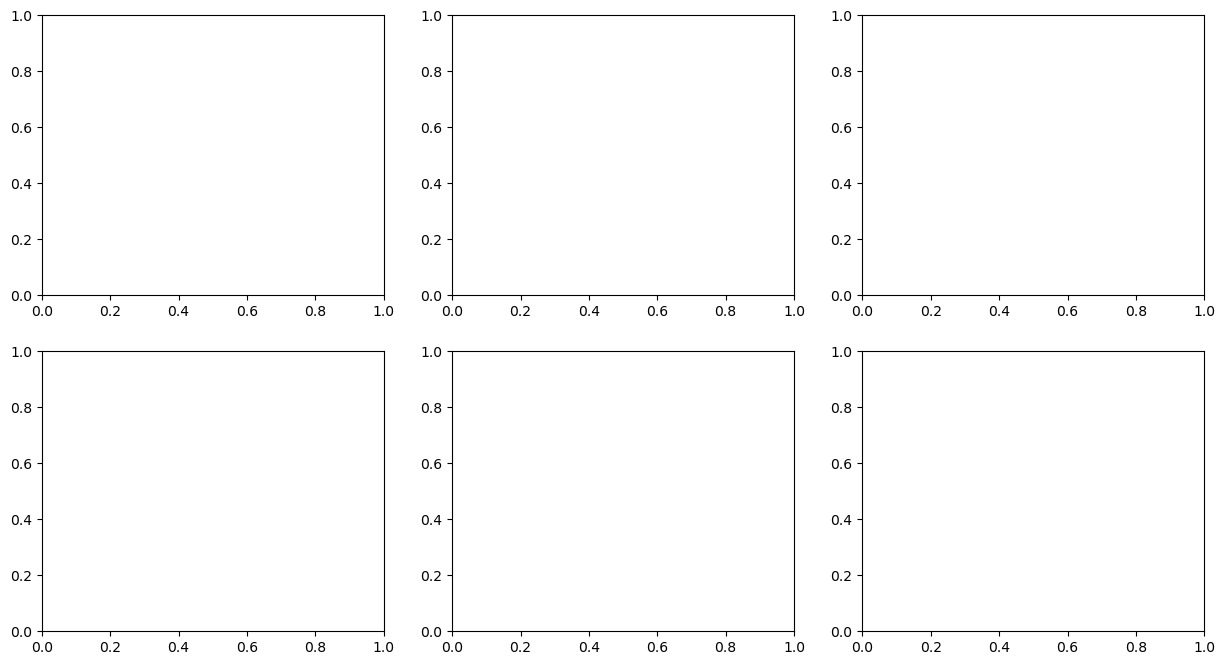

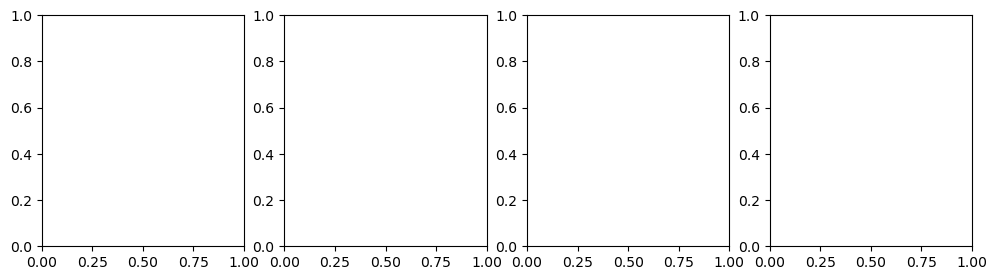

In [210]:
params = {
    'niter': 200,
    'a': 500,
    'pointsI': pointsI,
    'pointsJ': pointsJ,
    'sigmaMg': 0.25,
    'L': L,
    'T': T
}


results = LDDMM_gene_only_plot(
    xI=xI,
    xJ=xJ,
    Ig=XgI_subset,
    Jg=XgJ_subset,
    **params
)

In [ ]:
# plot rasterized images next to each other 
# get extent of images 
extentI = extent_from_x((Y,X))
extentJ = extent_from_x((Y,X))

# plot rasterized images 
fig,ax = plt.subplots(1,2)
ax[0].imshow(I_ct[0], extent=extentI)
ax[1].imshow(J_ct[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Rasterized Source Image, I")
ax[1].set_title("Rasterized Target Image, J")

In [164]:
xI=[YI, XI]
xJ=[YJ, XJ]

# Ensure images are 2D (height x width):
I = np.sum(XgI, axis=0)   # collapse genes if you want a single intensity image
J = np.sum(XgJ, axis=0)


In [166]:
YI.shape, XI.shape # height x width 

((741,), (705,))

In [167]:
YJ.shape, XJ.shape

((555,), (729,))

In [157]:
len(xI[0]), len(xI[1]), len(xJ[0]), len(xJ[1])

(741, 705, 555, 729)

In [159]:
YJ.shape[0]

555

In [160]:
print("I shape:", YI.shape)
print("xI[0] shape:", YgI.shape, "xI[1] shape:", XgI.shape)

I shape: (741,)
xI[0] shape: (85, 522405) xI[1] shape: (85, 741, 705)


In [172]:
print(XgI_subset.shape)  # (n_genes, H, W)
print(XgJ_subset.shape)  # (n_genes, H, W)

(12, 741, 705)
(12, 555, 729)


In [177]:
# 1. Determine common bounding box
x_min = min(list_I[0].min(), list_J[0].min())
x_max = max(list_I[0].max(), list_J[0].max())
y_min = min(list_I[1].min(), list_J[1].min())
y_max = max(list_I[1].max(), list_J[1].max())

# 2. Create grid
dx=15
x_grid = np.arange(x_min, x_max, dx)
y_grid = np.arange(y_min, y_max, dx)

# 3. Rasterize both datasets onto this grid
XgI, YgI, XI, YI = rasterizeByGene(list_I[0], list_I[1], GI, dx=dx, blur=1.5,
                                   x_range=x_grid, y_range=y_grid)
XgJ, YgJ, XJ, YJ = rasterizeByGene(list_J[0], list_J[1], GJ, dx=dx, blur=1.5,
                                   x_range=x_grid, y_range=y_grid)

TypeError: rasterizeByGene() got an unexpected keyword argument 'x_range'

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_98414/2951716990.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L, device=device, dtype=dtype, requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_98414/2951716990.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T, device=device, dtype=dtype, requires_grad=True)


RuntimeError: The size of tensor a (85) must match the size of tensor b (729) at non-singleton dimension 2

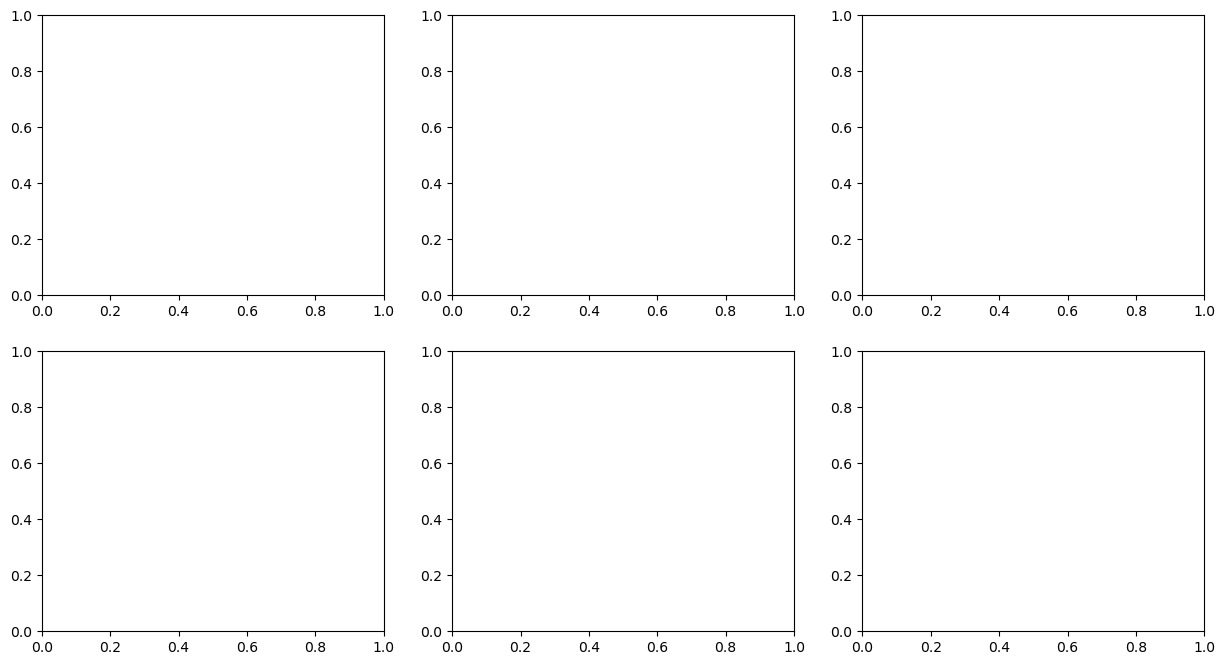

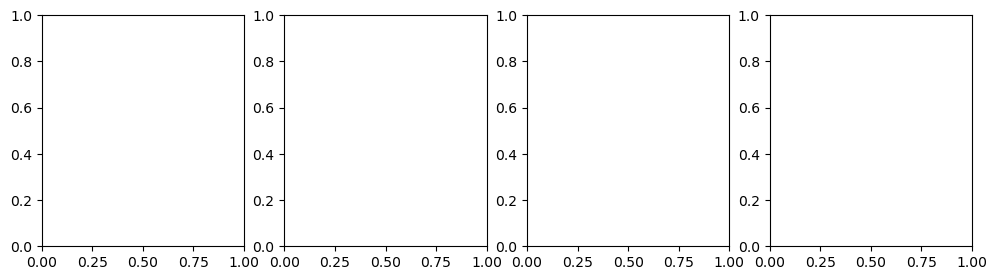

In [169]:
results = LDDMM_gene_only_plot(
    xI=xI, I=I,
    xJ=xJ, J=J,
    Ig=XgI_subset,  # <-- only candidate genes
    Jg=XgJ_subset,  # <-- only candidate genes
    pointsI=pointsI,
    pointsJ=pointsJ,
    **params
)

In [ ]:
params = {
    'niter': 200,
    'a': 500,
    'pointsI': pointsJ,
    'pointsJ': pointsI,
    'sigmaM': 0.25,
    'sigmaMg': 0.25,
    'A': A,
}

# Selecting spatially distinct genes
out_cell_g = LDDMM(
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    **params
)

In [ ]:
result = LDDMM(
    niter=1000,
    L=L, 
    T=T, 
    xI = xI, 
    I = I, 
    J = 

    xI, I, xJ, J, Ig, Jg,

    pointsI=pointsI, pointsJ=pointsJ,
    niter=1000, device='cpu'
)